# Mobility survey 2023

This notebook aims to analyze the mobility survey of Bogotá conducted in 2023.

In [1]:
# Calling the libreries 
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from pyproj import Geod
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from numba import njit
from datetime import datetime, timedelta, time

# Declaring the paths of the trips data
trips_path = r'./Encuesta de Movilidad 2023/EODH/CSV/Modulo_viajes.csv'
# Converting the CSV in a pandas dataframe
trips_df = pd.read_csv(trips_path, sep = ';', encoding='Windows-1252', low_memory=False)
# Path to the population data
houses_path = r'./Encuesta de Movilidad 2023/EODH/CSV/Modulo_hogares.csv'
# Converting the population data to a pandas df
houses_df = pd.read_csv(houses_path, sep=';', encoding='Windows-1252', low_memory=False)
# Path of the ZATs shapefiles
shape_path = r'./Encuesta de Movilidad 2023/03_Zonificacion EODH/ZAT2023/ZAT2023.shp'
# Calling the ZAT's shapefile
zats_map = gpd.read_file(shape_path)
# Path of the streets shapefile
streets_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/Malla_Vial_Integral_Bogota_D_C/Malla_Vial_Integral_Bogota_D_C.shp'
# Calling the streets shapefile
streets_map = gpd.read_file(streets_path)

# Converting the coordinate reference system of the ZATs shapefile in to be compatible
zats_map = zats_map.to_crs(streets_map.crs)
# Computing the centroid of each zat
zats_map['center'] = zats_map.to_crs('+proj=cea').centroid.to_crs(zats_map.crs)
zats_map = zats_map[(zats_map['MUNCod']==11001.0)|(zats_map['MUNCod']==25754.0)]

# Function which plots the place where a zat is located in Bogotá 
def one_zat(zat):
    df = zats_map[zats_map['ZAT']==zat]
    x_center = df['center'].x.iloc[0]
    y_center = df['center'].y.iloc[0]
    x_max = x_center+0.06
    x_min = x_center-0.06
    y_max = y_center+0.06
    y_min = y_center-0.06
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    streets_map.plot(ax = ax, color='grey')
    df.plot(color='g', ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.title('ZAT number {}'.format(zat), fontsize=40)
    plt.show()

# Function which plots the zat of origin and destination of a trip
def org_dest(zat_origin, zat_destination):
    x_origin = zats_map[zats_map['ZAT'] == zat_origin ]['center'].x.iloc[0]
    x_destination = zats_map[zats_map['ZAT'] == zat_destination]['center'].x.iloc[0]
    y_origin = zats_map[zats_map['ZAT'] == zat_origin ]['center'].y.iloc[0]
    y_destination = zats_map[zats_map['ZAT'] == zat_destination]['center'].y.iloc[0]
    x_max = max([x_origin, x_destination])+0.03
    x_min = min([x_origin, x_destination])-0.03
    y_max = max([y_origin, y_destination])+0.03
    y_min = min([y_origin, y_destination])-0.03
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    streets_map.plot(ax = ax, color='grey')
    zats_map[zats_map['ZAT'] == zat_origin ].plot(color='g', ax=ax)
    zats_map[zats_map['ZAT'] == zat_destination].plot(color='r', ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.title('ZAT of origin: {}, ZAT of destination: {}'.format(zat_origin, zat_destination), fontsize=40)
    plt.show()

In [361]:
# Filtering the data in order to take only the trips in Bogotá and Soacha
trips_df = trips_df[(trips_df['nom_mun_ori'] == 'Bogotá') | (trips_df['nom_mun_ori'] == 'Soacha')]
trips_df = trips_df[(trips_df['nom_mun_des'] == 'Bogotá') | (trips_df['nom_mun_des'] == 'Soacha')]
# Filtering the bucles 
trips_df = trips_df[trips_df['zat_ori'] != trips_df['zat_des']]
# Filtering the trips that are from or to Sumapaz
trips_df = trips_df[(trips_df['zat_ori'] != 796)]
trips_df = trips_df[(trips_df['zat_des'] != 796)]
trips_df = trips_df[(trips_df['zat_ori'] != 1151)]
trips_df = trips_df[(trips_df['zat_des'] != 1151)]

In [362]:
# Nodes with the highest degree

a = trips_df[['zat_ori', 'zat_des']]
b = trips_df[['zat_des', 'zat_ori']].rename(columns={'zat_des': 'zat_ori', 'zat_ori': 'zat_des'})
c = pd.concat([a, b]).drop_duplicates()
c.loc[0:, ['trips']] = 1
c = (c.groupby(['zat_ori'], as_index=False)['trips']
                        .agg('sum'))
c.sort_values(by='trips', ascending=False).head(10)

zat_ori  trips
267      275  324.0
917     1150  291.0
290      298  258.0
314      322  243.0
918     1152  239.0
268      276  236.0
851      997  228.0
247      255  225.0
490      501  218.0
159      167  209.0

## Statistics

In this section, we are going to verify the statistics of the survey to determine if the data is reliable.

In [363]:
# Number of surveys, zones and trips
num_surv = len(houses_df)
num_trips = len(trips_df)
num_nodes = len(set(trips_df['zat_ori']).union(set(trips_df['zat_des'])))
info_dict = {'Number of surveys': num_surv, 'Number of trips': num_trips, 'Number of ZATs': num_nodes}
info_dict

{'Number of surveys': 22755, 'Number of trips': 72931, 'Number of ZATs': 929}

Primero que nada es relevante notar los cambios relevantes en la encuesta, el muestreo y la red.

|         | 2019   | 2023  |
|---------|--------|-------|
| Houses  | 18719  | 22755 |
| Trips   | 105215 | 73180 |
| Nodes   | 900    | 931   |

Lo primero que podemos ver es que se tienen mas hogares encuestados en el 2023 que en el 2019,pero se registran menos viajes a lo largo de la red en 2023, lo cual se manifiesta en una red menos densa, en especial cuando se tienen mas nodos en 2023, esta combinación de menos viajes y menos nodos da lugar a una red mucho menos densa. 

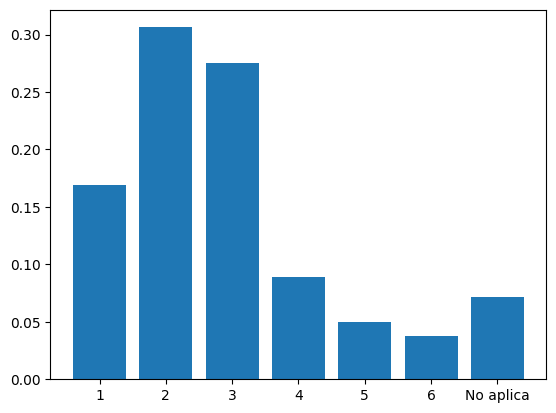

In [364]:
# Population per socioeconomic level

strata_trips, counts_st_trips = np.unique(trips_df['estra_hg'], return_counts=True)
counts_st_trips = counts_st_trips/sum(counts_st_trips)

plt.bar(strata_trips, counts_st_trips)
plt.show()

In [365]:
counts_st_trips

array([0.16933814, 0.30628951, 0.27560297, 0.08897451, 0.04993761,
       0.03783028, 0.07202698])

Se pueden apreciar numerosas diferencias entre las poblaciones de cada encuesta, la primera diferencía está en que las encuestas que no tienen un estrato determinado pasaron de ser menos a mas del 5% de las muestras, el estrato 1 crecio mucho, pasando de un 10% a un 15% de los encuestados, mientras que el estrato 4 decrecio bastante, pasando de un 14% de los registros a tan solo el 9%.
Por otra parte, los estratos 2, 3, 5 y 6 no presentan cambios tan significativos en el porcentaje de la muestra.

In [366]:
# Population per district 
loc = houses_df[houses_df['cod_mpio_hg'] == 11001]['nom_loc_hg']
loc, loc_counts = np.unique(loc, return_counts=True)
loc_counts = loc_counts/sum(loc_counts)
loc_dict = {'District': loc, 'Population': loc_counts}
pd.DataFrame(loc_dict).sort_values(by='Population', ascending=False)

District  Population
7              Kennedy    0.107106
4       Ciudad Bolívar    0.106078
14                Suba    0.086485
18             Usaquén    0.074032
5             Engativá    0.071918
6             Fontibón    0.068605
19                Usme    0.061179
11  Rafael Uribe Uribe    0.060037
16         Teusaquillo    0.059865
3            Chapinero    0.056266
12       San Cristóbal    0.039586
10       Puente Aranda    0.038501
13            Santa Fe    0.038215
2                 Bosa    0.038101
1       Barrios Unidos    0.035988
0       Antonio Nariño    0.017080
17          Tunjuelito    0.015252
9         Los Mártires    0.014852
8        La Candelaria    0.006798
15             Sumapaz    0.004056

La diferencía mas relevante es el alto porcentaje en el muestreo que Ciudad Bolivar representa, a pesar de que localidades como Suba, Engativa o Fontibón son mas pobladas. 
Otro punto relevante es la baja cantidad de encuestas es lo subrepresentada que se encuentra Bosa, poniendo localidades menos pobladas por delante de ella, como Chapinero o incluso Usme.

## Network properties

In [367]:
# Calling the needed dataframe

df_path = r'./Encuesta de Movilidad 2023/EODH/CSV/num_dis_trips.csv'
num_dis_trips = pd.read_csv(df_path)
# Adding the in nodal strength of the origin node
s_in = num_dis_trips[['zat_des', 'Destination Trips']].drop_duplicates()
num_dis_trips = (num_dis_trips.merge(s_in, left_on='zat_ori', right_on='zat_des')
                              .drop(columns=['zat_des_y', 'Unnamed: 0'])
                              .rename(columns={'zat_des_x': 'zat_des', 'Destination Trips_x': 'Destination Trips', 'Destination Trips_y': 'Origin in strength'}))
# Filtering the trips that are from or goes to Sumapaz
num_dis_trips = num_dis_trips[num_dis_trips['zat_ori'] != 796]
num_dis_trips = num_dis_trips[num_dis_trips['zat_des'] != 796]
num_dis_trips = num_dis_trips[num_dis_trips['zat_ori'] != 1151]
num_dis_trips = num_dis_trips[num_dis_trips['zat_des'] != 1151]

num_dis_trips

zat_ori  zat_des  Origin Trips  Destination Trips  Org Nodal Strength  \
0          366      364         190.0              399.0               380.0   
1          366      335         190.0              141.0               380.0   
2          366      334         190.0               28.0               380.0   
3          366      433         190.0              223.0               380.0   
4          366      368         190.0               34.0               380.0   
...        ...      ...           ...                ...                 ...   
41367        3     1156           3.0               18.0                 6.0   
41368      490      611           1.0              196.0                 3.0   
41369      988      650           1.0               96.0                 2.0   
41370     1053     1020           1.0                8.0                 2.0   
41371     1010      945           1.0               26.0                 2.0   

       Dest Nodal Strength     Distances  Trips      s_ij     S_ij  \
0                    793.0    445.726603   90.0      32.0     16.0   
1                    281.0   1062.328746   12.0    2082.0   1053.0   
2                     55.0    877.428142    6.0    1203.0    607.0   
3                    439.0   1562.108800    3.0    4133.0   2091.0   
4                     65.0   1209.179221    3.0    2440.0   1233.0   
...                    ...           ...    ...       ...      ...   
41367                 35.0    778.775778    2.0       2.0      1.0   
41368                386.0   4792.769506    1.0   20306.0  10173.0   
41369                187.0   8049.113131    1.0   84986.0  42534.0   
41370                 15.0    878.638769    1.0      40.0     20.0   
41371                 51.0  25882.203413    1.0  117310.0  58741.0   

       Origin in strength  
0                   190.0  
1                   190.0  
2                   190.0  
3                   190.0  
4                   190.0  
...                   ...  
41367                 3.0  
41368                 2.0  
41369                 1.0  
41370                 1.0  
41371                 1.0  

[41279 rows x 11 columns]

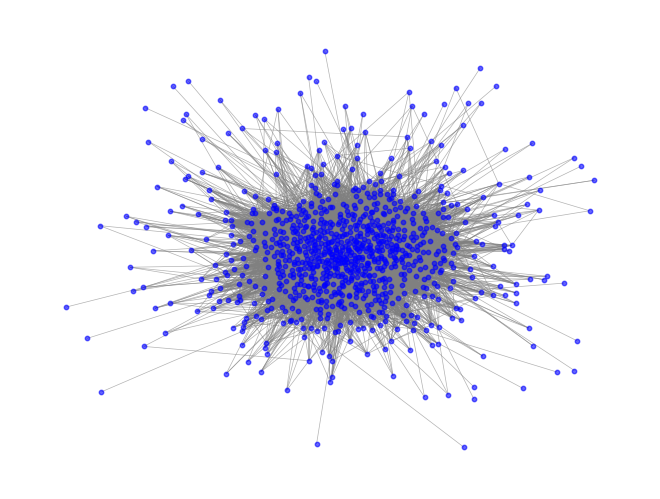

In [368]:
# Vizualizing the network and saving the edge list
edge_list = trips_df[['zat_ori', 'zat_des']]
G_bogota = nx.from_pandas_edgelist(edge_list, 'zat_ori', 'zat_des')

# Saving the edge list as a gexf file
nx.write_gexf(G_bogota, r'./Encuesta de Movilidad 2023/bogota_net.gexf')

# Ploting the network
pos = nx.spring_layout(G_bogota, k=0.15, iterations=20)
nx.draw(G_bogota, pos, node_size=10, node_color='blue', alpha=0.6, edge_color='gray', width=0.5)
plt.show()

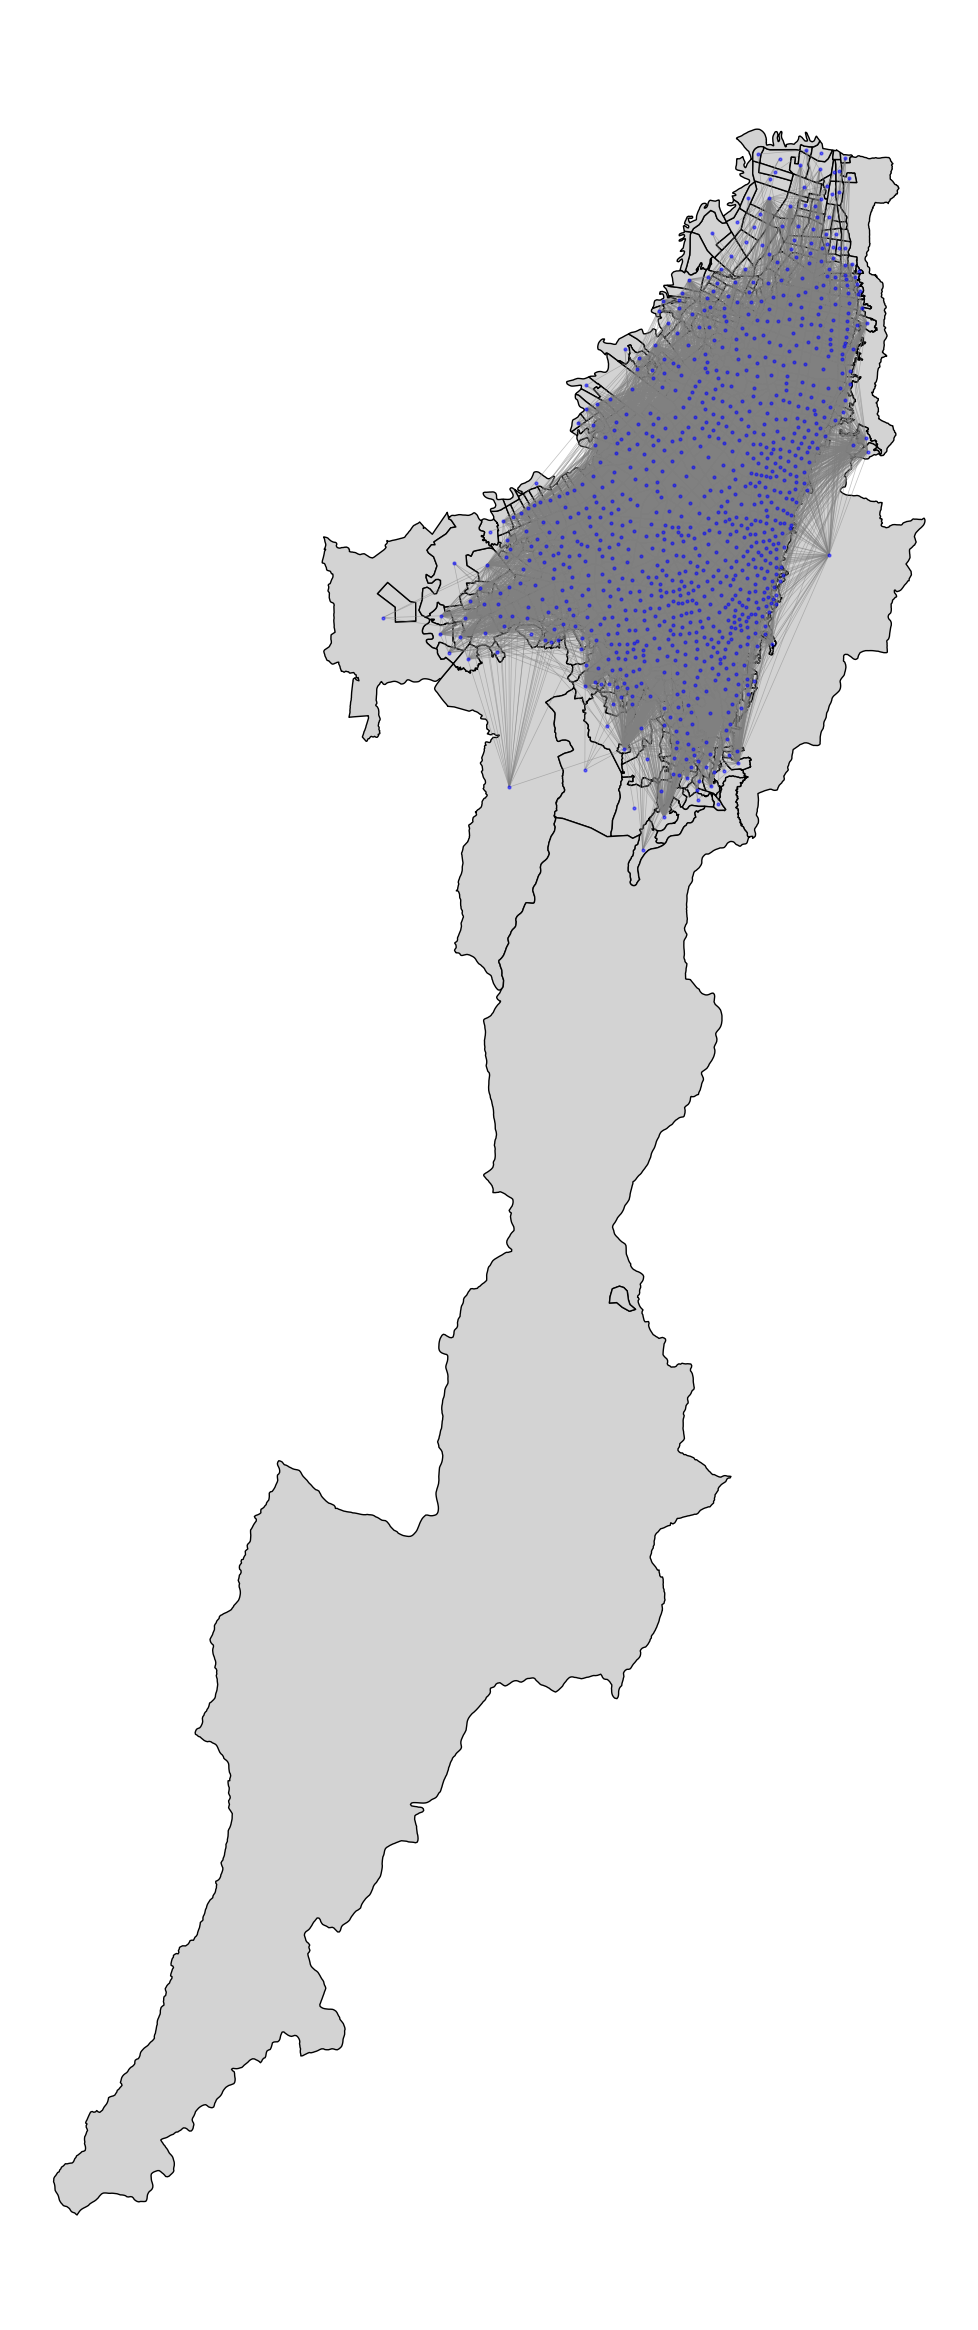

In [369]:
pos = {}

for idx, row in zats_map.iterrows():
    zone_id = row['ZAT']
    centroid = row.geometry.centroid
    pos[zone_id] = (centroid.x, centroid.y)

nx.set_node_attributes(G_bogota, pos, 'pos')

# Graficar el shapefile
fig, ax = plt.subplots(figsize=(30, 30))
zats_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Obtener posiciones de los nodos
pos = nx.get_node_attributes(G_bogota, 'pos')

# Graficar el grafo
nx.draw(G_bogota, pos, ax=ax, node_color='blue', edge_color='gray', with_labels=False, node_size=4, width=0.5, alpha=0.5)

plt.show()

### Non directed Network

In [370]:
# Speedrun of the non directed topological properties of the network

# Function that computes the distribution and the cdf of a determinate array or column of a dataframe
def dist_and_ccdf(array):
    x, y = np.unique(np.array(array), return_counts=True)
    y = y/sum(y)
    # Average degree
    avg = np.mean(array)
    # Computing de CCDF of the degree
    ccdf = [sum(y[i:]) for i in range(len(y))]
    dist_array = [x, y, ccdf]
    return dist_array, avg

# Function that returns the degree distribution and the average degree
def non_dir_degree(df):
    # Edge list columns
    edges = ['zat_ori', 'zat_des']
    edge_list = df[edges]
    # Symmetric edge list
    other_edges = ['zat_des', 'zat_ori']
    # Converting the directed network to a non-directed
    new_edge_list = edge_list[other_edges].rename(columns={other_edges[0]: edges[0], other_edges[1]: edges[1]})
    edge_list = pd.concat([edge_list, new_edge_list]).drop_duplicates()
    edge_list.loc[0:, ['trips']] = 1
    # Computing the degree of each node
    edge_list = (edge_list.groupby(edges[0], as_index=False)['trips']
                        .agg('sum'))
    # Degree probability
    degree_dist, k_avg = dist_and_ccdf(edge_list['trips'])

    return degree_dist, k_avg

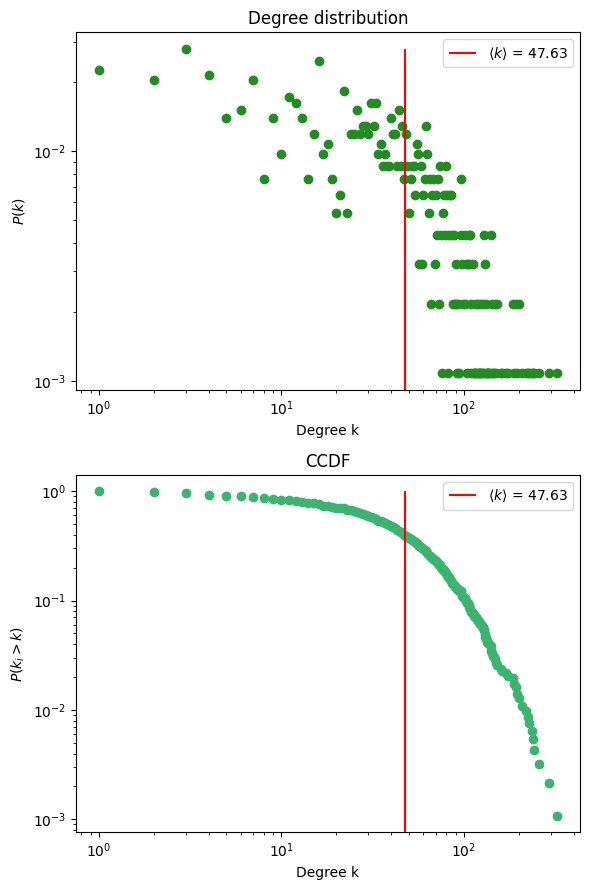

In [371]:
degree_dist, k_avg = non_dir_degree(num_dis_trips)

# Ploting the degree distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(degree_dist[0], degree_dist[1], color = 'forestgreen')
ax[0].vlines(k_avg, 0, max(degree_dist[1]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Degree k')
ax[0].set_ylabel(r'$P(k)$')
ax[0].set_title('Degree distribution')
ax[0].legend()

ax[1].scatter(degree_dist[0], degree_dist[2], color = 'mediumseagreen')
ax[1].vlines(k_avg, 0, max(degree_dist[2]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Degree k')
ax[1].set_ylabel(r'$P(k_i>k)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

La primera gran diferencia entre ambas encuestas viene con el grado promedio, en donde se paso de tener casi $\langle k \rangle = 80$ a $\langle k \rangle = 48$. La cuestión con este resultado es que no se conoce a ciencia cierta porque se ha dado este fenomieno, la primera hipotesis es decir que es consecuencía de la pandemia, pero también puede ser consecuencia de la manera en que se llevo a cabo el muestreo. 

Fenomenologicamente, viendo el comportamiento de la distribución, vemos que en forma se conserva, suguiendo un comportamiento aproximadamente exponencial, pero que no cae lo suficientemente rapido. 

In [372]:
# Function that returns the nodal strength distribution and their mean
def non_dir_strength(df):
    # Nodal strength columns
    str_out_col = ['zat_ori', 'Org Nodal Strength']
    str_out =df[str_out_col]
    str_in_col = ['zat_des', 'Dest Nodal Strength']
    str_in = df[str_in_col]
    # Merging the total nodal strengths
    str_in = str_in.rename(columns={'zat_des': 'zat_ori', 'Dest Nodal Strength': 'Org Nodal Strength'})
    nodal_str = pd.concat([str_out, str_in]).drop_duplicates()
    str_array = np.array(nodal_str[str_out_col[1]])
    str_dist, str_avg = dist_and_ccdf(str_array)

    return str_dist, str_avg

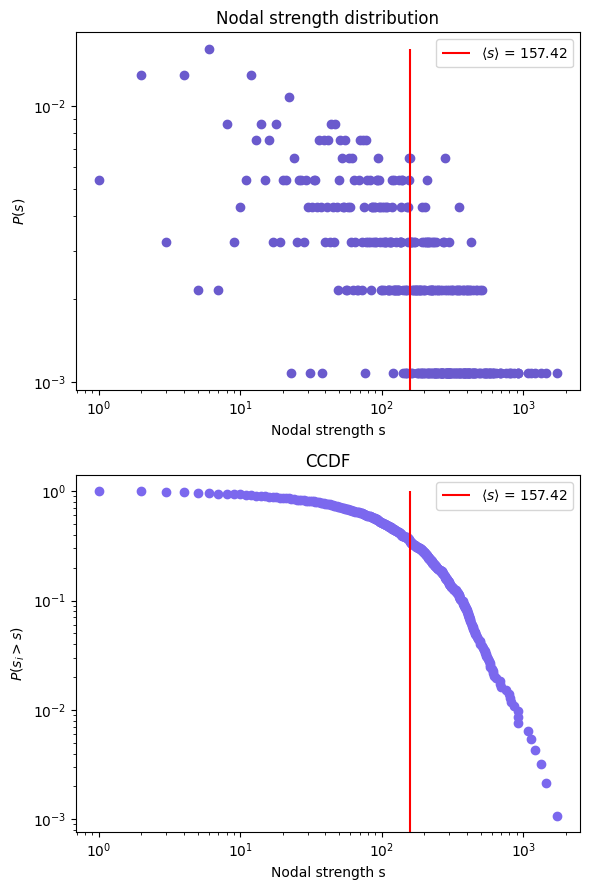

In [373]:
str_dist, str_avg = non_dir_strength(num_dis_trips)

# Ploting the nodal strength distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(str_dist[0], str_dist[1], color = 'slateblue')
ax[0].vlines(str_avg, 0, max(str_dist[1]), label=r'$\langle s \rangle$ = {}'.format(round(str_avg, 2)), color='r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Nodal strength s')
ax[0].set_ylabel(r'$P(s)$')
ax[0].set_title('Nodal strength distribution')
ax[0].legend()

ax[1].scatter(str_dist[0], str_dist[2], color = 'mediumslateblue')
ax[1].vlines(str_avg, 0, max(str_dist[2]), label=r'$\langle s \rangle$ = {}'.format(round(str_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Nodal strength s')
ax[1].set_ylabel(r'$P(s_i>s)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

Se tiene la misma diferencia que en el caso del grado, un valor medio menor para el caso del 2023, pero se tiene una diferencia fundamental, la cola del 2023 decae menos rapido que la del 2019, y aproximandose mas hacia un comportamiento tipo ley de potencias.

In [374]:
# Function that returns the link's weight (number of trips between two zones) distribution and the average
def non_dir_weight(df):
    # Nondirected weighted links 
    weigth_1 = ['zat_ori', 'zat_des', 'Trips']
    weigth_2 = ['zat_des', 'zat_ori', 'Trips']
    w_list_1 = df[weigth_1]
    w_list_2 = df[weigth_2]

    # Probability of a nondirected weigthed link
    w_list_2 = w_list_2.rename(columns={weigth_2[0]: weigth_1[0], weigth_2[1]: weigth_1[1]})
    w_list = pd.concat([w_list_1, w_list_2])
    w_list = (w_list.groupby([weigth_1[0], weigth_1[1]], as_index=False)['Trips']
                    .agg('sum'))
    w_array = np.array(w_list['Trips'])
    w_dist, w_avg = dist_and_ccdf(w_array)

    return w_dist, w_avg

In [375]:
weigth_1 = ['zat_ori', 'zat_des', 'Trips']
weigth_2 = ['zat_des', 'zat_ori', 'Trips']
w_list_1 = num_dis_trips[weigth_1]
w_list_2 = num_dis_trips[weigth_2]

w_list_2 = w_list_2.rename(columns={weigth_2[0]: weigth_1[0], weigth_2[1]: weigth_1[1]})
w_list = pd.concat([w_list_1, w_list_2])
w_list = (w_list.groupby([weigth_1[0], weigth_1[1]], as_index=False)['Trips']
                .agg('sum'))
w_list.sort_values(by='Trips', ascending=False)

zat_ori  zat_des  Trips
19089      366      364  178.0
18931      364      366  178.0
43976     1152      714  152.0
35187      714     1152  152.0
43735     1150      725  152.0
...        ...      ...    ...
37925      781      354    1.0
18624      362      330    1.0
7759       180      667    1.0
37915      781      245    1.0
34289      687      645    1.0

[44200 rows x 3 columns]

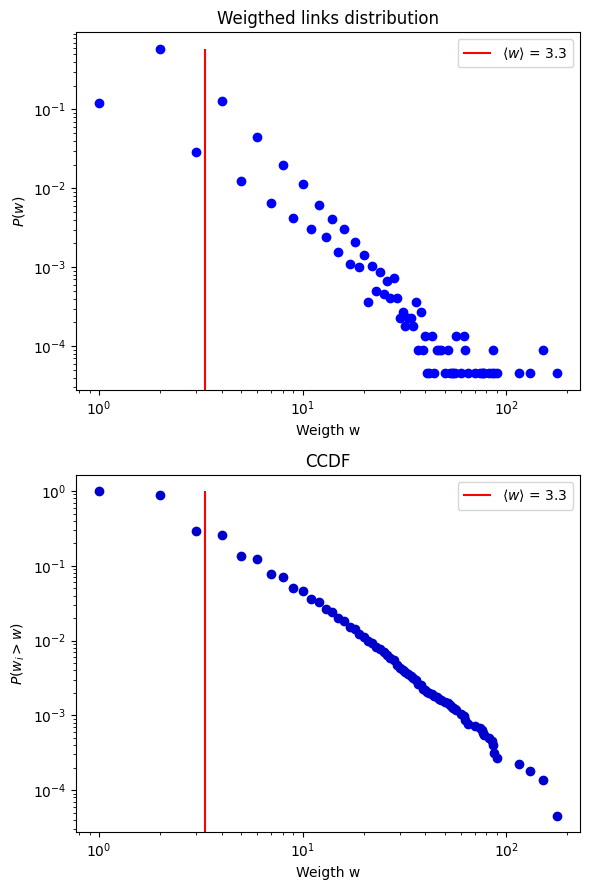

In [376]:
w_dist, w_avg = non_dir_weight(num_dis_trips)

# Ploting the link's weigth distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(w_dist[0], w_dist[1], color = 'blue')
ax[0].vlines(w_avg, 0, max(w_dist[1]), label=r'$\langle w \rangle$ = {}'.format(round(w_avg, 2)), color='r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Weigth w')
ax[0].set_ylabel(r'$P(w)$')
ax[0].set_title('Weigthed links distribution')
ax[0].legend()

ax[1].scatter(w_dist[0], w_dist[2], color = 'mediumblue')
ax[1].vlines(w_avg, 0, max(w_dist[2]), label=r'$\langle w \rangle$ = {}'.format(round(w_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Weigth w')
ax[1].set_ylabel(r'$P(w_i>w)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

En ambos casos se tiene una ley de potencias, pero con la diferencia en que los links de la red del 2023 son mas pesados en promedio que el caso del 2019.

### Direced network 

In [377]:
# Function that returns the in and out nodal strength 
def in_out_strength(df):
    # Calling the columns
    out_columns = ['zat_ori', 'Origin Trips']
    in_columns = ['zat_des', 'Destination Trips']
    # Calling the df
    out_df = df[out_columns]
    in_df = df[in_columns]
    # Removing repeated values
    out_df = out_df.drop_duplicates()
    in_df = in_df.drop_duplicates()

    out_w_dis, out_w_avg = dist_and_ccdf(out_df['Origin Trips'])
    in_w_dis, in_w_avg = dist_and_ccdf(in_df['Destination Trips'])
    
    return out_w_dis, out_w_avg, in_w_dis, in_w_avg

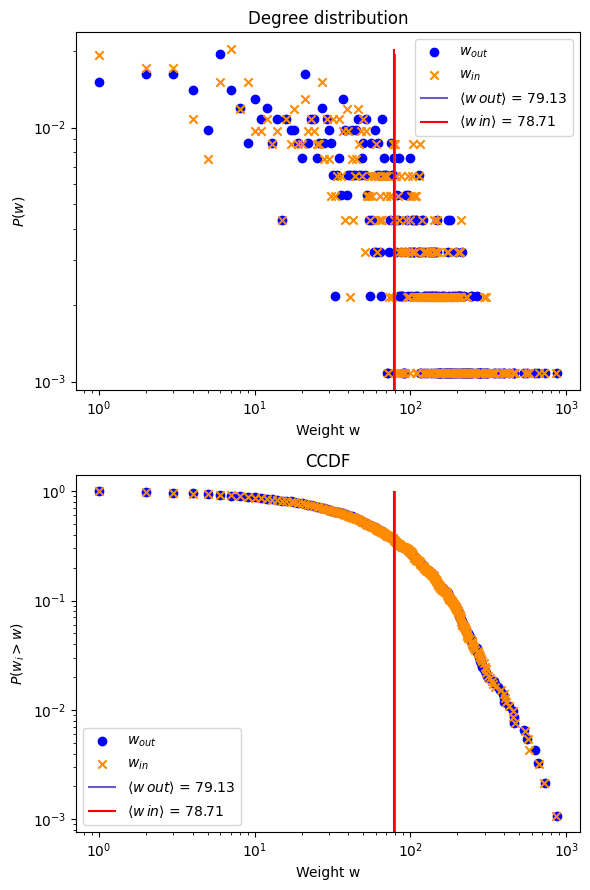

In [378]:
# Computing the deistribution for the in out strength dist and the directed link's weight

out_w_dis, out_w_avg, in_w_dis, in_w_avg = in_out_strength(num_dis_trips)

# out_w_dis, out_w_avg = dist_and_ccdf(num_dis_trips['Origin Trips'])
# in_w_dis, in_w_avg = dist_and_ccdf(num_dis_trips['Destination Trips'])

# Ploting the degree distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(out_w_dis[0], out_w_dis[1], color = 'b', label=r'$w_{out}$')
ax[0].scatter(in_w_dis[0], in_w_dis[1], color = 'darkorange', marker='x', label=r'$w_{in}$')
ax[0].vlines(out_w_avg, 0, max(out_w_dis[1]), label=r'$\langle w \, out \rangle$ = {}'.format(round(out_w_avg, 2)), color='slateblue')
ax[0].vlines(in_w_avg, 0, max(in_w_dis[1]), label=r'$\langle w \, in \rangle$ = {}'.format(round(in_w_avg, 2)), color='r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Weight w')
ax[0].set_ylabel(r'$P(w)$')
ax[0].set_title('Degree distribution')
ax[0].legend()

ax[1].scatter(out_w_dis[0], out_w_dis[2], color = 'b', label=r'$w_{out}$')
ax[1].scatter(in_w_dis[0], in_w_dis[2], color = 'darkorange', marker='x', label=r'$w_{in}$')
ax[1].vlines(out_w_avg, 0, max(out_w_dis[2]), label=r'$\langle w \, out \rangle$ = {}'.format(round(out_w_avg, 2)), color='slateblue')
ax[1].vlines(in_w_avg, 0, max(in_w_dis[2]), label=r'$\langle w \, in \rangle$ = {}'.format(round(in_w_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Weight w')
ax[1].set_ylabel(r'$P(w_i>w)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

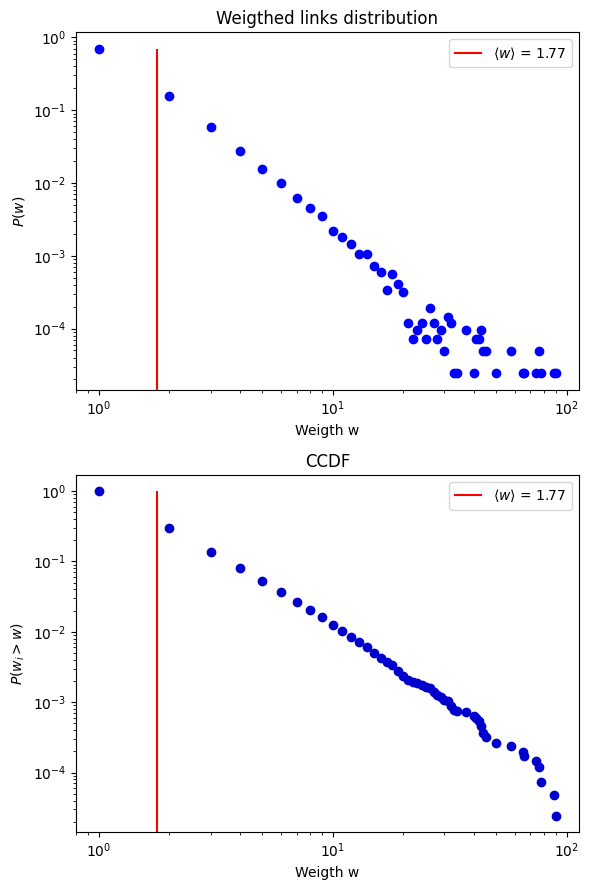

In [379]:
# Computing the distribution of the non directed links 
dir_w_dist, dir_w_avg = dist_and_ccdf(num_dis_trips['Trips'])

# Ploting the  nodal strength distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(dir_w_dist[0], dir_w_dist[1], color = 'blue')
ax[0].vlines(dir_w_avg, 0, max(dir_w_dist[1]), label=r'$\langle w \rangle$ = {}'.format(round(dir_w_avg, 2)), color='r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Weigth w')
ax[0].set_ylabel(r'$P(w)$')
ax[0].set_title('Weigthed links distribution')
ax[0].legend()

ax[1].scatter(dir_w_dist[0], dir_w_dist[2], color = 'mediumblue')
ax[1].vlines(dir_w_avg, 0, max(dir_w_dist[2]), label=r'$\langle w \rangle$ = {}'.format(round(dir_w_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Weigth w')
ax[1].set_ylabel(r'$P(w_i>w)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

## Models

### Gravitational Model

In this section, we are going to evaluate the accuracy with which three different types of the gravitational model fit the processed data.

The three models are.
1. $T_{ij}=\frac{O_iD_j}{R^{\alpha}}$
2. $T_{ij}=K\frac{O_iD_j}{R^{\alpha}}$
3. $T_{ij} = K\frac{(O_iD_j)^{\beta}}{d_{ij}^{\alpha}}$

In [380]:
# Declaring the three diferent versions of the gravitational model

# First gravitational model
def grav_model_1(Data, a):
    O_1, D_2, d = Data
    T = (O_1*D_2)/(d**a)
    T = T/sum(T)
    return T

# Second gravitational model
def grav_model_2(Data, K, a):
    O_1, D_2, d = Data
    T = K*(O_1*D_2)/(d**a)
    T = T/sum(T)
    return T

# Third gravitational model
def grav_model_3(Data, K, a, b):
    O_1, D_2, d = Data
    T = K*(O_1*D_2)**b/(d**a)
    T = T/sum(T)
    return T

In [381]:
# Fiting the gravitational model per a percentge of the trips

def fiting_grav_models(df, frac):
    # Number of total trips in Bogotá
    t_trips = 10.2e6*frac

    # Calling the parameters to fit with the model
    origin = np.array(df['Origin Trips'])
    dest = np.array(df['Destination Trips'])
    distance = np.array(df['Distances'])

    # Array with the number of non-simetrical (directed) trips between zats
    trips = np.array(df['Trips'])
    
    # Reescaling the origin and destination trips
    origin = origin*t_trips/sum(trips)
    dest = dest*t_trips/sum(trips)

    trips = trips/sum(trips)

    # Tupple with the free parameters
    data = (origin, dest, distance)

    # Fiting the data with the first model
    popt_1, pcov_1 = curve_fit(grav_model_1, data, trips)
    # Fiting the data with the second model
    popt_2, pcov_2 = curve_fit(grav_model_2, data, trips)
    # Fiting the data with the third model
    popt_3, pcov_3 = curve_fit(grav_model_3, data, trips)

    # Computing the theoretical data
    theo_trips_1 = grav_model_1(data, popt_1[0])
    theo_trips_2 = grav_model_2(data, popt_2[0], popt_2[1])
    theo_trips_3 = grav_model_3(data, popt_3[0], popt_3[1], popt_3[2])

    return trips*t_trips, theo_trips_1*t_trips, theo_trips_2*t_trips, theo_trips_3*t_trips

In [382]:
# Function that plot the comparation of the model with the real data

def plot_real_theo_grav(trips, theo_trips_1, theo_trips_2, theo_trips_3):
    # t_trips = 10.2e6*frac


    # Seting the minimum and maximum value to plot the identity line
    min_point = (min(trips), min(trips))
    max_point = (max(trips), max(trips))

    # Plotng the comparation
    fig, ax = plt.subplots(3, figsize=(7, 14))

    ax[0].scatter(trips, theo_trips_1, color='mediumpurple')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Real data')
    ax[0].set_ylabel('Predicted data')
    ax[0].axline(min_point, max_point)
    ax[0].set_title('Gravitational models')
    ax[0].grid()

    ax[1].scatter(trips, theo_trips_2, color='mediumseagreen')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Real data')
    ax[1].set_ylabel('Predicted data')
    ax[1].axline(min_point, max_point)
    ax[1].grid()

    ax[2].scatter(trips, theo_trips_3, color='salmon')
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].set_xlabel('Real data')
    ax[2].set_ylabel('Predicted data')
    ax[2].axline(min_point, max_point)
    ax[2].grid()

    plt.tight_layout()
    plt.show()

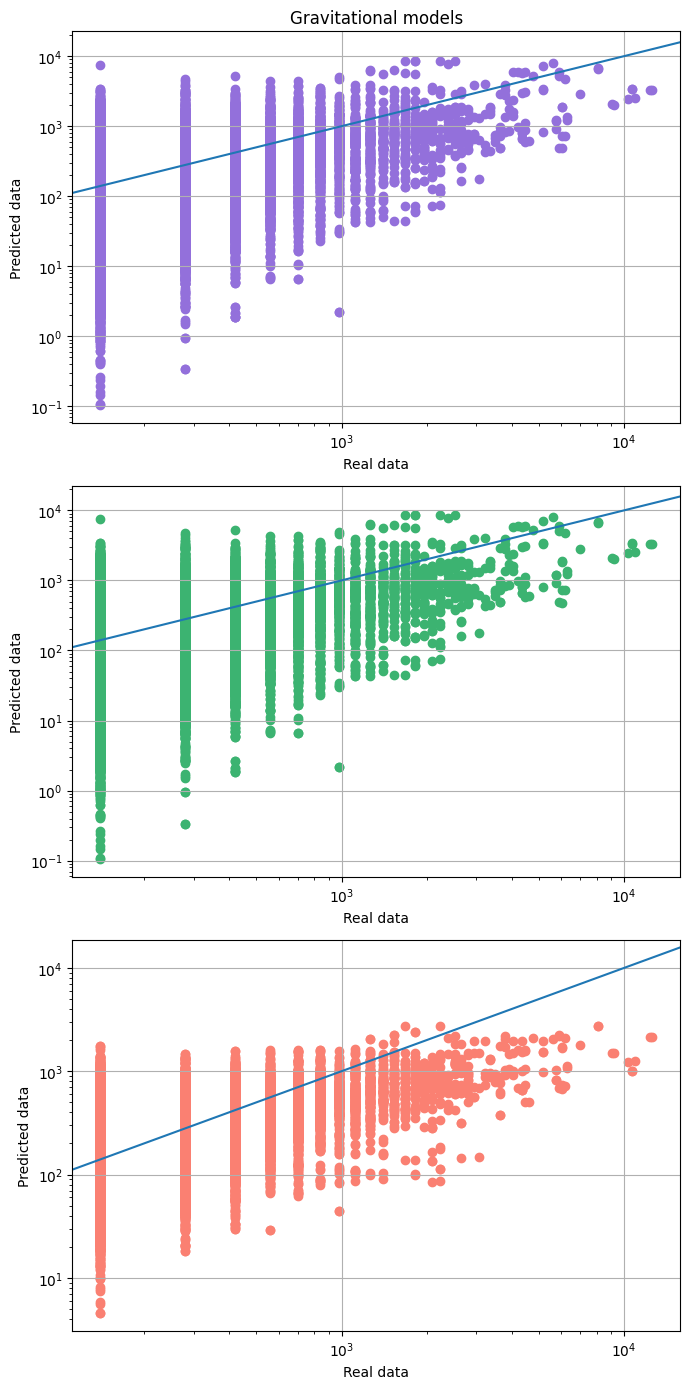

In [383]:
trips, theo_trips_1, theo_trips_2, theo_trips_3 = fiting_grav_models(num_dis_trips, 1)
plot_real_theo_grav(trips, theo_trips_1, theo_trips_2, theo_trips_3)

In [384]:
num_dis_trips

zat_ori  zat_des  Origin Trips  Destination Trips  Org Nodal Strength  \
0          366      364         190.0              399.0               380.0   
1          366      335         190.0              141.0               380.0   
2          366      334         190.0               28.0               380.0   
3          366      433         190.0              223.0               380.0   
4          366      368         190.0               34.0               380.0   
...        ...      ...           ...                ...                 ...   
41367        3     1156           3.0               18.0                 6.0   
41368      490      611           1.0              196.0                 3.0   
41369      988      650           1.0               96.0                 2.0   
41370     1053     1020           1.0                8.0                 2.0   
41371     1010      945           1.0               26.0                 2.0   

       Dest Nodal Strength     Distances  Trips      s_ij     S_ij  \
0                    793.0    445.726603   90.0      32.0     16.0   
1                    281.0   1062.328746   12.0    2082.0   1053.0   
2                     55.0    877.428142    6.0    1203.0    607.0   
3                    439.0   1562.108800    3.0    4133.0   2091.0   
4                     65.0   1209.179221    3.0    2440.0   1233.0   
...                    ...           ...    ...       ...      ...   
41367                 35.0    778.775778    2.0       2.0      1.0   
41368                386.0   4792.769506    1.0   20306.0  10173.0   
41369                187.0   8049.113131    1.0   84986.0  42534.0   
41370                 15.0    878.638769    1.0      40.0     20.0   
41371                 51.0  25882.203413    1.0  117310.0  58741.0   

       Origin in strength  
0                   190.0  
1                   190.0  
2                   190.0  
3                   190.0  
4                   190.0  
...                   ...  
41367                 3.0  
41368                 2.0  
41369                 1.0  
41370                 1.0  
41371                 1.0  

[41279 rows x 11 columns]

In [385]:
theo_trips_1

array([3.32215538e+03, 7.11489908e+02, 1.57759259e+02, ...,
       7.93107094e-01, 2.37043433e-01, 1.09531503e-01])

Antes que nada una breve explicación de que significa cada punto y de mis escalas de medida. Cada punto representa un viaje o un edge no dirigido de la red, el eje x da la probabilidad que tiene ese viaje de suceder segun los datos reales, mientras que el eje y nos dice la probabilidad que tiene ese viaje en particular segun el modelo, y la gracia es que estas dos medidas sean lo mas parecidas entre si, i.e, que al hacer el plot de real probababilities vs predicted probabilities, los datos se acerquen mas a la recta real. 

Tenemos particularmente dos comportamientos bien determinados en los tres modelos gravitacionales propuestos, en el primer y segundo caso se tiene una especie de lucha entre la tendencia y el orden de magnitud, y en el tercer modelo los ordenes de magnitud se mantienen controlados, pero la tendencía no es reproducida.

Teniendo el cuenta los dos primeros modelos, en el caso de los viajes altmente probables (edges muy pesados), vemos que la tendencia de los datos reales es equiparable con la tendencia predicha, pero para el caso de viajes poco probables(edges con un peso de 1 o un poco mas), vemos que el modelo predice que un conjunto considerable de estos viajes son hasta mil veces menos probables que lo que nos dicen los datos reales, lo cual nos dice que existen viajes, no muy numerosos, que el modelo los califica como practicamente imposibles que sucedan[mobility_models_2019.ipynb].

En el tercer modelo no se sigue un coportamiento del todo igual al caso del 2019, lo que vemos primero es que el modelo es simetrico logaritmicamente en los edges con un solo viaje, dado que se ajusta a esta gran cantidad de datos, pero, las conexiones mas pesadas se ajustan de una mejor manera en comparación a los resultados obtenidos en el 2019, en donde los valores teoricos si superan la barrera de los $10^{-4}$.

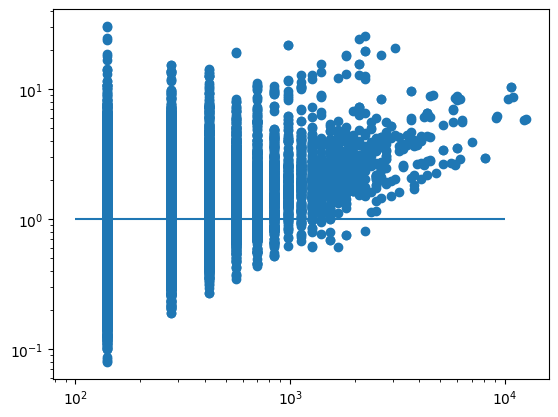

In [386]:
# Variability

plt.scatter(trips, trips/theo_trips_3)
plt.hlines(1, xmin=1e2, xmax=1e4)
plt.xscale('log')
plt.yscale('log')

### Radiation Model

In [387]:
# Function that computes the predicted values of the radiation model
def radiation_model(df, frac):
    T_i = np.array(df['Origin Trips'])
    m_i = np.array(df['Org Nodal Strength'])
    m_j = np.array(df['Dest Nodal Strength'])
    s_ij = np.array(df['s_ij'])
    T_ij = T_i*(m_i*m_j)/((m_i+s_ij)*(m_i+m_j+s_ij))
    T_ij = T_ij/sum(T_ij)
    
    return T_ij*10.2e6*frac

In [388]:
# Ploting the acuracy of the model
def plot_radiation(df, T_ij, frac):
    rad_trips = (df['Trips']/sum(df['Trips']))*10.2e6*frac
    # rad_trips = df['Trips']
    min_point = (min(rad_trips), min(rad_trips))
    max_point = (max(rad_trips), max(rad_trips))

    plt.figure()
    plt.scatter(rad_trips, T_ij, color='plum')
    plt.axline(min_point, max_point)
    plt.xlabel('Real trips')
    plt.ylabel('Predicted trips')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Radiation Model')
    plt.grid()
    plt.show()

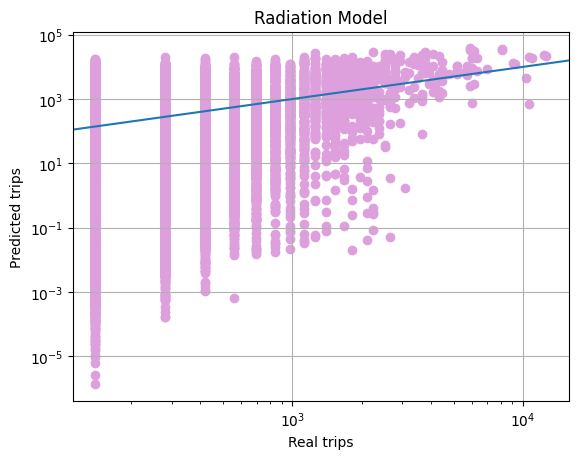

In [389]:
T_ij = radiation_model(num_dis_trips, 1)
plot_radiation(num_dis_trips, T_ij, 1)

Fenomenologicamente se sigue casi que el mismo comportamiento que en el 2019 incluso con aun mas datos extraños en donde las predicciones son menos precisas. 

### Network Radiation Model

Teniendo en cuenta el articulo Gravity vs Radiation en Reino Unido, se puede traducir este modelo a cantidades puras de las redes, y con la normalización correcta para sistemas finitos, el modelo está dado por.

$w_{ij} = \frac{s_i^{out}}{1-\frac{s_i^{in}}{\sum_{ij}w_{ij}}} \frac{s_i^{in}s_j^{in}}{(s_i^{in}+S_{ij})(s_i^{in}+s_j^{in}+S_{ij})}$

Para este modelo, cuento facilmente con todos los datos, excepto con $S_{ij}$ debido a que, este está definido como $S_{ij} = \sum_{k \in K_{ij}} s_k^{in}$, y yo en el caso anterior defini esta cantidad con la fuerza nodal total, así que toca recalcular esta cantidad.

In [390]:
num_dis_trips

zat_ori  zat_des  Origin Trips  Destination Trips  Org Nodal Strength  \
0          366      364         190.0              399.0               380.0   
1          366      335         190.0              141.0               380.0   
2          366      334         190.0               28.0               380.0   
3          366      433         190.0              223.0               380.0   
4          366      368         190.0               34.0               380.0   
...        ...      ...           ...                ...                 ...   
41367        3     1156           3.0               18.0                 6.0   
41368      490      611           1.0              196.0                 3.0   
41369      988      650           1.0               96.0                 2.0   
41370     1053     1020           1.0                8.0                 2.0   
41371     1010      945           1.0               26.0                 2.0   

       Dest Nodal Strength     Distances  Trips      s_ij     S_ij  \
0                    793.0    445.726603   90.0      32.0     16.0   
1                    281.0   1062.328746   12.0    2082.0   1053.0   
2                     55.0    877.428142    6.0    1203.0    607.0   
3                    439.0   1562.108800    3.0    4133.0   2091.0   
4                     65.0   1209.179221    3.0    2440.0   1233.0   
...                    ...           ...    ...       ...      ...   
41367                 35.0    778.775778    2.0       2.0      1.0   
41368                386.0   4792.769506    1.0   20306.0  10173.0   
41369                187.0   8049.113131    1.0   84986.0  42534.0   
41370                 15.0    878.638769    1.0      40.0     20.0   
41371                 51.0  25882.203413    1.0  117310.0  58741.0   

       Origin in strength  
0                   190.0  
1                   190.0  
2                   190.0  
3                   190.0  
4                   190.0  
...                   ...  
41367                 3.0  
41368                 2.0  
41369                 1.0  
41370                 1.0  
41371                 1.0  

[41279 rows x 11 columns]

In [391]:
# Function that computes the network version of the radiation model
def net_radiation_model(df, frac):
    s_i_out = np.array(df['Origin Trips'])
    s_i_in = np.array(df['Origin in strength'])
    s_j_in = np.array(df['Destination Trips'])
    S_ij = np.array(df['S_ij'])
    tot_trips = sum(df['Trips'])
    norm = s_i_out/(1-s_i_in/tot_trips)
    w_ij = norm*(s_i_in*s_j_in/((s_i_in+S_ij)*(s_i_in+s_j_in+S_ij)))
    w_ij = w_ij/sum(w_ij)

    return w_ij*10.2e6*frac

In [392]:
sum(trips)

10199999.999995628

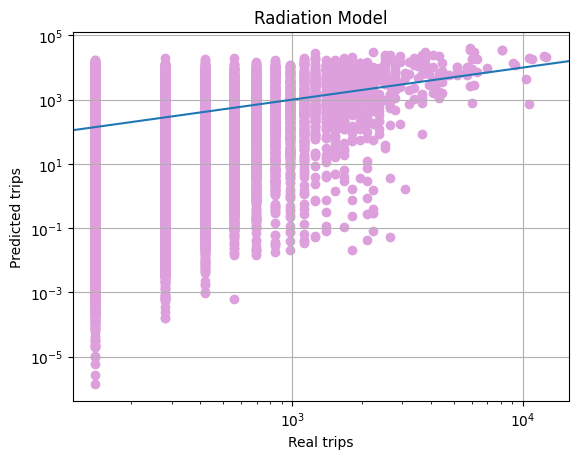

In [393]:
# Ploting the model
w_ij = net_radiation_model(num_dis_trips, 1)
plot_radiation(num_dis_trips, w_ij, 1)

## Correlations

En esta sección se estudiran la dependencia del numero de viajes entre dos zonas en función de la distncia, la fuerza nodal de entrada $s_j^{in}$, y el numero de oportunidades $S_{ij}$ tal vez

In [394]:
# Creating a dataframe with all the needed information
dist = np.array(num_dis_trips['Distances'])
s_j_in = np.array(num_dis_trips['Destination Trips'])*10.2e6/sum(num_dis_trips['Destination Trips'])
corr_dict = {'Real Trips': trips, 'Distances': dist, r's_j_in': s_j_in,'Gravity 1': theo_trips_1, 'Gravity 2': theo_trips_2, 'Gravity 3': theo_trips_3, 'Radiation': w_ij}
corr_df = pd.DataFrame(corr_dict).sort_values(by='Distances')

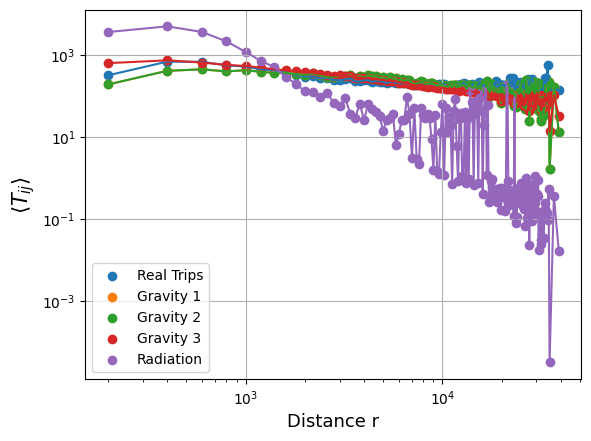

In [456]:
# Ploting the dependance of the mean number of commuters in function of the distance of the trips

def convert_values(arr):
    def convert_value(val):
        # Redondear al múltiplo de 200 más cercano
        return round(val / 200) * 200

    # Aplicar la conversión a cada elemento del array
    return np.array([convert_value(x) for x in arr])

array = convert_values(np.array(corr_df['Distances']))

corr_dist = {'Real Trips': corr_df['Real Trips'], 'Distances': array, 'Gravity 1': corr_df['Gravity 1'], 'Gravity 2': corr_df['Gravity 2'], 'Gravity 3': corr_df['Gravity 3'], 'Radiation': corr_df['Radiation']}
corr_dist = pd.DataFrame(corr_dist)
# Averaging over the distances
columns = ['Real Trips', 'Gravity 1', 'Gravity 2', 'Gravity 3', 'Radiation']
corr_dist = (corr_dist.groupby('Distances', as_index=False)[columns]
                    .agg('mean')
                    .sort_values(by='Distances'))

# Poloting the results
plt.figure()
plt.scatter(corr_dist['Distances'], corr_dist['Real Trips'], label='Real Trips')
plt.plot(corr_dist['Distances'], corr_dist['Real Trips'])
plt.scatter(corr_dist['Distances'], corr_dist['Gravity 1'], label='Gravity 1')
plt.plot(corr_dist['Distances'], corr_dist['Gravity 1'])
plt.scatter(corr_dist['Distances'], corr_dist['Gravity 2'], label='Gravity 2')
plt.plot(corr_dist['Distances'], corr_dist['Gravity 2'])
plt.scatter(corr_dist['Distances'], corr_dist['Gravity 3'], label='Gravity 3')
plt.plot(corr_dist['Distances'], corr_dist['Gravity 3'])
plt.scatter(corr_dist['Distances'], corr_dist['Radiation'], label='Radiation')
plt.plot(corr_dist['Distances'], corr_dist['Radiation'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Distance r', fontsize=13)
plt.ylabel(r'$\langle T_{ij} \rangle$', fontsize=15)
plt.legend()
plt.grid()
plt.show()

In [409]:
def convert_values_log(arr):
    def convert_value_log(val):
        if val < 950:
            # Para valores menores de 950, usamos un paso de 100
            return ((val // 100) + 1) * 100
        else:
            # Para valores mayores o iguales a 950, usamos pasos de potencias de 10
            magnitude = 10 ** int(np.log10(val))
            return ((val // magnitude) + 1) * magnitude

    # Aplicar la conversión a cada elemento del array
    return np.array([convert_value_log(x) for x in arr])

# Ejemplo de uso
arr = np.array([180, 260, 1000, 1600, 30000])
converted_arr = convert_values(arr)

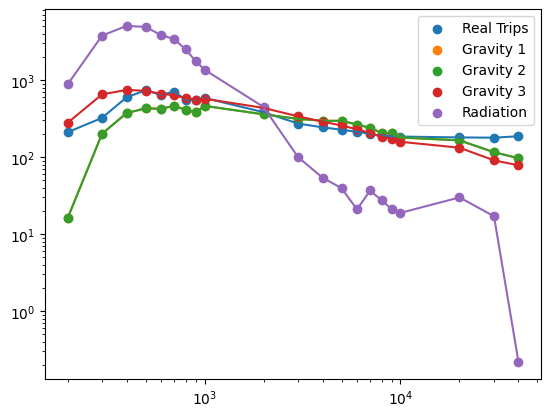

In [410]:
array = convert_values_log(np.array(corr_df['Distances']))

corr_dist = {'Real Trips': corr_df['Real Trips'], 'Distances': array, 'Gravity 1': corr_df['Gravity 1'], 'Gravity 2': corr_df['Gravity 2'], 'Gravity 3': corr_df['Gravity 3'], 'Radiation': corr_df['Radiation']}
corr_dist = pd.DataFrame(corr_dist)
# Averaging over the distances
columns = ['Real Trips', 'Gravity 1', 'Gravity 2', 'Gravity 3', 'Radiation']
corr_dist = (corr_dist.groupby('Distances', as_index=False)[columns]
                    .agg('mean')
                    .sort_values(by='Distances'))

# Poloting the results
plt.figure()
plt.scatter(corr_dist['Distances'], corr_dist['Real Trips'], label='Real Trips')
plt.plot(corr_dist['Distances'], corr_dist['Real Trips'])
plt.scatter(corr_dist['Distances'], corr_dist['Gravity 1'], label='Gravity 1')
plt.plot(corr_dist['Distances'], corr_dist['Gravity 1'])
plt.scatter(corr_dist['Distances'], corr_dist['Gravity 2'], label='Gravity 2')
plt.plot(corr_dist['Distances'], corr_dist['Gravity 2'])
plt.scatter(corr_dist['Distances'], corr_dist['Gravity 3'], label='Gravity 3')
plt.plot(corr_dist['Distances'], corr_dist['Gravity 3'])
plt.scatter(corr_dist['Distances'], corr_dist['Radiation'], label='Radiation')
plt.plot(corr_dist['Distances'], corr_dist['Radiation'])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

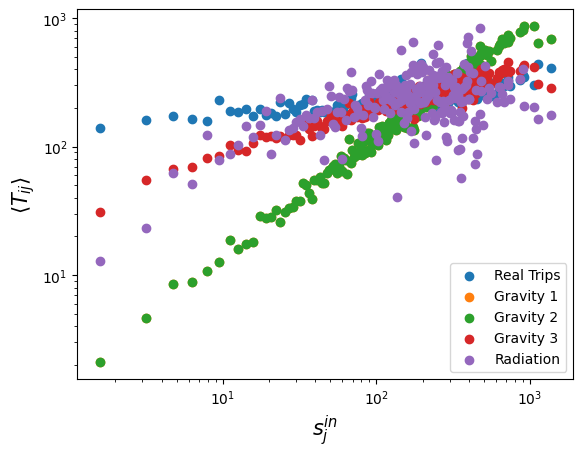

In [462]:
corr_s_i = (corr_df.groupby('s_j_in', as_index=False)[columns]
                    .agg('mean')
                    .sort_values(by='s_j_in'))

# Poloting the results
plt.figure()
plt.scatter(corr_s_i['s_j_in'], corr_s_i['Real Trips'], label='Real Trips')
plt.scatter(corr_s_i['s_j_in'], corr_s_i['Gravity 1'], label='Gravity 1')
plt.scatter(corr_s_i['s_j_in'], corr_s_i['Gravity 2'], label='Gravity 2')
plt.scatter(corr_s_i['s_j_in'], corr_s_i['Gravity 3'], label='Gravity 3')
plt.scatter(corr_s_i['s_j_in'], corr_s_i['Radiation'], label='Radiation')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$s_j^{in}$', fontsize=15)
plt.ylabel(r'$\langle T_{ij} \rangle$', fontsize=15)
plt.legend()
plt.show()

### Correlation discussion

1. Primero que nada vamos a discutir la dependencia de numero de viajeros $\langle T_{ij} \rangle$ en función de la distancia, como era de esperarse, tanto los modelos como los datos reales muestran que el numero medio de viajeros entre doz zonas disminulle a medida que estas están mas alejadas, la diferencia es la velocidad con la que esta cantidad viaja, lo primero que podemos observar es que, de todos los modelos, el que decae mas rapido con la distancia es el de radiaciones, el cual llega a tener cantidades menores a la unidad, y presenta una gran canctidad de ruido para distancias grandes. Este modelo no se acercca e lo absoluto a la tendencia que siguen los viajes reales, y solo se intersectan en un punto despues del kilometro de distancia. Estos resultados van en concordancia con lo obtenido en [Masucci 2013], en donde se realizo un estudio por el estudio en Londres, y el modelo de radiaciones presentaba el mismo comportamiento para zonas mas pequeñas en una misma area urbana. El modelo de radiaciones prueba ser mas util en el contexto de viajes entre poblaciones separadas y municipalidades.

2. Segundo comentario es que los dos primeros gravitacionales son practicamente equivalentes, y no muestran alguna diferencia significativa que haga util su diferenciación, por lo cual solo se tendrá en cuenta el segundo modelo gravitacional. Lo siguiente a notar es que el modelo sigue un comportamiento mas acorde a los datos reales en función de la distncia el cual no termina de ajustar bien para distancias pequeñas, pero en algún momento despues de 1km, se ajusta con los datos reales hasta llegados los 12km, en donde presenta una  caida estrepitosa en el numero de viajeros, esto sucede porque el termino $1/R^{\alpha}$ decae mucho mas rapido que el valor de las fuerzas nodales.

3. Por ultimo vamos a discutir sobre la tercera versión del modelo gravitacional el cual reproduce de mejor manera el comportamiento de los datos reales en función de la distancia, dado que sigue el comportamiento de los datos reales a partir de una distancia de 400 metros. Este ajuste se debe a que el termino que decae con la distancia se compensa con la potencia a la cual estan elevados las fuerzas nodales de origen y destino, sin enmbargo para los viajes mas cortos, de al rededor de 200 metros, el decaimento en función de la distancia no compensa las fuerzas nodales, por lo cual se predicen mas viajes de los que en verdad hay. Otro commportamiento importante es que a partir de los 10 kilometros este modelo tiende a alejarse del comportamiento de los datos reales presentando un decaimiento mas rapido, producto de que el termino $1/R^{\alpha}$ decae mas rapido de lo que el valor de las fuerzas nodales, incluso se llega a apreciar que este modelo presenta un decaimiento mas rapido que el segundo modelo gravitacional.

De manera general se pueden redactar varias conclusiones, la primera es que definitivamente, el modelo de radiaciones no funciona para predecir los viajes dentro de una misma area urbana, al menos para el caso de Bogotá, ya que la cantidad de viajes que predice en funcióon de la distancia dista bastante del comportamiento de los datos reales, segundo, para distancias cortas, de entre 400 metros y 10 km el modelo gravitacional 3 presenta una una aproximación decente al comportamiento deseado, pero para distancias mas grandes el segundo modelo gravitacional se ajusta mas, pero no de manera satisfactoria, por lo cual es neesario plantear algún modelo diferente especifico para viajes con grandes distancias.
Con los modelos trabajados se pueden obtener predicciones decentes si los viajes se dan en una distancia entre los 400 metros y los 10 km aproximadamente, en particular haciendo uso del tercer modelo gravitacional.

Teniendo en cuenta la fuerza nodal de entrada $s_j^{in}$, se pueden observar otros comportamientos importantes. Primero que nada, como comportamiento general se puede observar que tanto los datos reales como los modelos presentan un crecimiento en función de la fuerza nodal del nodo de entrada, pero cada uno crece de manera diferente, el mas alejado de todos es el segundo modelo gravitacional, en donde se tiene un crecimiento mucho mas rapido pero que para valores pequeños de $s_j^{in}$ no es capaz de predecir tantos viajeros. Por otra parte el tercer modelo gravitacional y el modelo de radiaciones presentan comportamientos similares en donde crecen al mismo ritmo, y en un punto donde la fuerza nodal supera los 100 viajes, se aproximan de manera considerable a al comportamiento de los datos reales. 

Otra conclusión puede darse a partir de este analisis y es que, en el rango de viajes cuya distancia está entre los 400 metros y los 10 km en linea recta, y la fuerza nodal de los nodos de llegada es mayor a 100, el tercer modelo gravitacional da la aproximación mas decente a los datos reales, y este resultado sirve como base para plantear modelos que den explicación de los datos en un rango mas amplio.

## Analysis per Socio-Economic level

In [412]:
# Calling the dataframes in function of the socioeconomic level
path_1 = r'./Encuesta de Movilidad 2023/EODH/CSV/estrato_1.csv'
path_2 = r'./Encuesta de Movilidad 2023/EODH/CSV/estrato_2.csv'
path_3 = r'./Encuesta de Movilidad 2023/EODH/CSV/estrato_3.csv'
path_4 = r'./Encuesta de Movilidad 2023/EODH/CSV/estrato_4.csv'
path_5 = r'./Encuesta de Movilidad 2023/EODH/CSV/estrato_5.csv'
path_6 = r'./Encuesta de Movilidad 2023/EODH/CSV/estrato_6.csv'

level_1_df = pd.read_csv(path_1)
level_2_df = pd.read_csv(path_2)
level_3_df = pd.read_csv(path_3)
level_4_df = pd.read_csv(path_4)
level_5_df = pd.read_csv(path_5)
level_6_df = pd.read_csv(path_6)

# Filtering the trips that have origin or destination in Sumapaz
def filtering_sumapz(df):
    new_df = df[df['zat_ori'] != 796]
    new_df = new_df[new_df['zat_des'] != 796]
    new_df = new_df[new_df['zat_ori'] != 1151]
    new_df = new_df[new_df['zat_des'] != 1151]

    return new_df

level_1_df = filtering_sumapz(level_1_df)
level_2_df = filtering_sumapz(level_2_df)
level_3_df = filtering_sumapz(level_3_df)
level_4_df = filtering_sumapz(level_4_df)
level_5_df = filtering_sumapz(level_5_df)
level_6_df = filtering_sumapz(level_6_df)

# Adding the in nodal strength of the origin node
def org_in_strength(df):
    str_in = df[['zat_des', 'Destination Trips']].drop_duplicates()
    # Adding the nodes where their destination in nodal strenght is zero
    nodes = set(df['zat_ori'])-set(df['zat_des'])
    nodes = list(nodes)
    dst_trips = np.zeros(len(nodes))
    nodes_df = pd.DataFrame({'zat_des': nodes, 'Destination Trips': dst_trips})
    str_in = pd.concat([str_in, nodes_df], ignore_index=True)
    mod_df = (df.merge(str_in, left_on='zat_ori', right_on='zat_des')
                           .drop(columns=['zat_des_y', 'Unnamed: 0'])
                           .rename(columns={'zat_des_x': 'zat_des', 'Destination Trips_x': 'Destination Trips', 'Destination Trips_y': 'Origin in strength'}))
    return mod_df

level_1_df = org_in_strength(level_1_df)
level_2_df = org_in_strength(level_2_df)
level_3_df = org_in_strength(level_3_df)
level_4_df = org_in_strength(level_4_df)
level_5_df = org_in_strength(level_5_df)
level_6_df = org_in_strength(level_6_df)


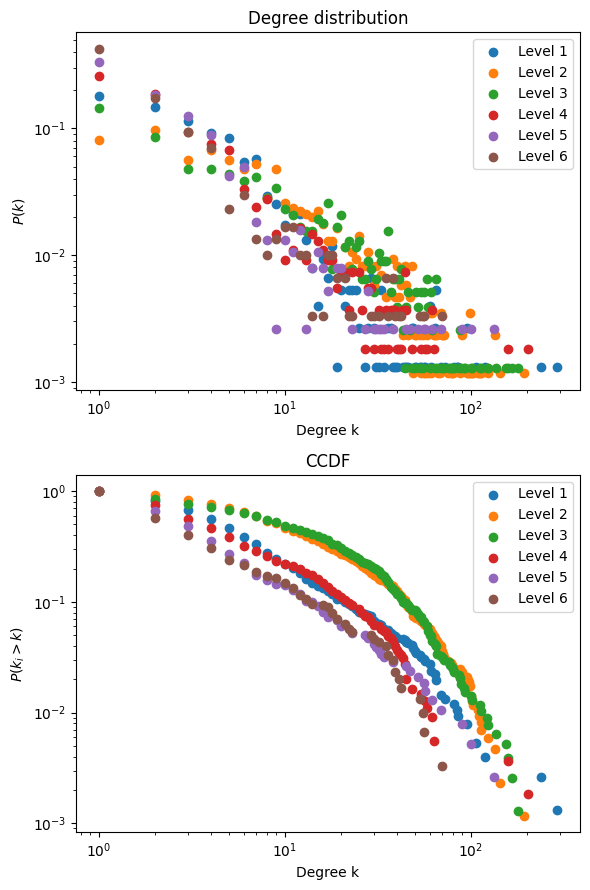

In [413]:
# Mesuring the degree dist of each level network
degree_1, k_1_avg = non_dir_degree(level_1_df)
degree_2, k_2_avg = non_dir_degree(level_2_df)
degree_3, k_3_avg = non_dir_degree(level_3_df)
degree_4, k_4_avg = non_dir_degree(level_4_df)
degree_5, k_5_avg = non_dir_degree(level_5_df)
degree_6, k_6_avg = non_dir_degree(level_6_df)

# Ploting the degree distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(degree_1[0], degree_1[1], label='Level 1')
ax[0].scatter(degree_2[0], degree_2[1], label='Level 2')
ax[0].scatter(degree_3[0], degree_3[1], label='Level 3')
ax[0].scatter(degree_4[0], degree_4[1], label='Level 4')
ax[0].scatter(degree_5[0], degree_5[1], label='Level 5')
ax[0].scatter(degree_6[0], degree_6[1], label='Level 6')
# ax[0].vlines(k_1_avg, 0, max(degree_1[1]), label=r'$\langle k_1 \rangle$ = {}'.format(round(k_1_avg, 2)))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Degree k')
ax[0].set_ylabel(r'$P(k)$')
ax[0].set_title('Degree distribution')
ax[0].legend()

ax[1].scatter(degree_1[0], degree_1[2], label='Level 1')
ax[1].scatter(degree_2[0], degree_2[2], label='Level 2')
ax[1].scatter(degree_3[0], degree_3[2], label='Level 3')
ax[1].scatter(degree_4[0], degree_4[2], label='Level 4')
ax[1].scatter(degree_5[0], degree_5[2], label='Level 5')
ax[1].scatter(degree_6[0], degree_6[2], label='Level 6')
# ax[1].vlines(k_avg, 0, max(degree_dist[2]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Degree k')
ax[1].set_ylabel(r'$P(k_i>k)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

In [414]:
# Showing the average degree per level
degree_dict = {'Level 1': k_1_avg, 
               'Level 2': k_2_avg, 
               'Level 3': k_3_avg, 
               'Level 4': k_4_avg,
               'Level 5': k_5_avg,
               'Level 6': k_6_avg}
degree_dict

{'Level 1': 9.43989431968296,
 'Level 2': 17.19766081871345,
 'Level 3': 17.718709677419355,
 'Level 4': 8.164835164835164,
 'Level 5': 6.125984251968504,
 'Level 6': 5.46843853820598}

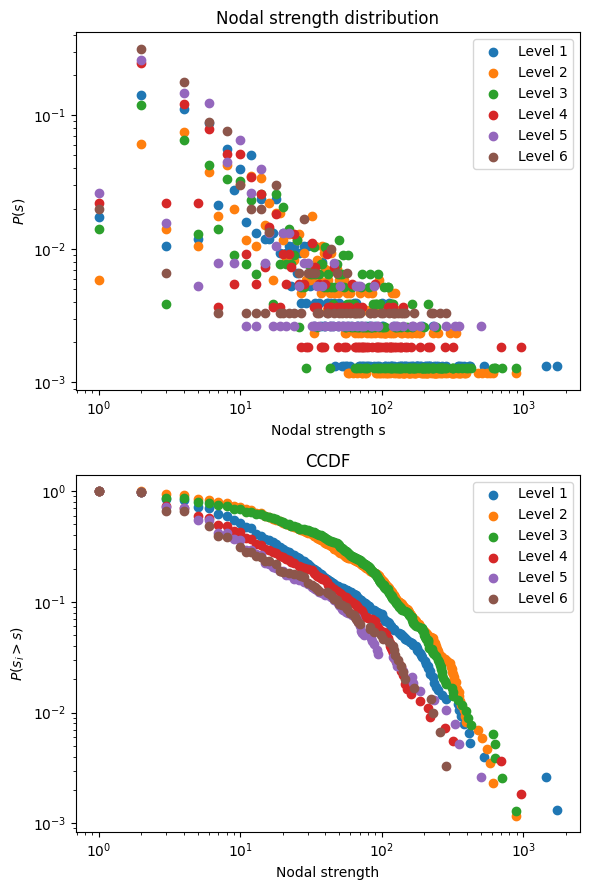

In [415]:
# Nodal strength distribution per each level

strength_1, avg_str_1 = non_dir_strength(level_1_df)
strength_2, avg_str_2 = non_dir_strength(level_2_df)
strength_3, avg_str_3 = non_dir_strength(level_3_df)
strength_4, avg_str_4 = non_dir_strength(level_4_df)
strength_5, avg_str_5 = non_dir_strength(level_5_df)
strength_6, avg_str_6 = non_dir_strength(level_6_df)

# Ploting the nodal strength distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(strength_1[0], strength_1[1], label='Level 1')
ax[0].scatter(strength_2[0], strength_2[1], label='Level 2')
ax[0].scatter(strength_3[0], strength_3[1], label='Level 3')
ax[0].scatter(strength_4[0], strength_4[1], label='Level 4')
ax[0].scatter(strength_5[0], strength_5[1], label='Level 5')
ax[0].scatter(strength_6[0], strength_6[1], label='Level 6')
# ax[0].vlines(k_1_avg, 0, max(degree_1[1]), label=r'$\langle k_1 \rangle$ = {}'.format(round(k_1_avg, 2)))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Nodal strength s')
ax[0].set_ylabel(r'$P(s)$')
ax[0].set_title('Nodal strength distribution')
ax[0].legend()

ax[1].scatter(strength_1[0], strength_1[2], label='Level 1')
ax[1].scatter(strength_2[0], strength_2[2], label='Level 2')
ax[1].scatter(strength_3[0], strength_3[2], label='Level 3')
ax[1].scatter(strength_4[0], strength_4[2], label='Level 4')
ax[1].scatter(strength_5[0], strength_5[2], label='Level 5')
ax[1].scatter(strength_6[0], strength_6[2], label='Level 6')
# ax[1].vlines(k_avg, 0, max(degree_dist[2]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Nodal strength')
ax[1].set_ylabel(r'$P(s_i>s)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

In [416]:
# Showing the average strength per level
strength_dict = {'Level 1': avg_str_1, 
               'Level 2': avg_str_2, 
               'Level 3': avg_str_3, 
               'Level 4': avg_str_4,
               'Level 5': avg_str_5,
               'Level 6': avg_str_6}
strength_dict

{'Level 1': 32.78731836195509,
 'Level 2': 52.36023391812866,
 'Level 3': 51.873548387096776,
 'Level 4': 23.763736263736263,
 'Level 5': 19.11548556430446,
 'Level 6': 18.325581395348838}

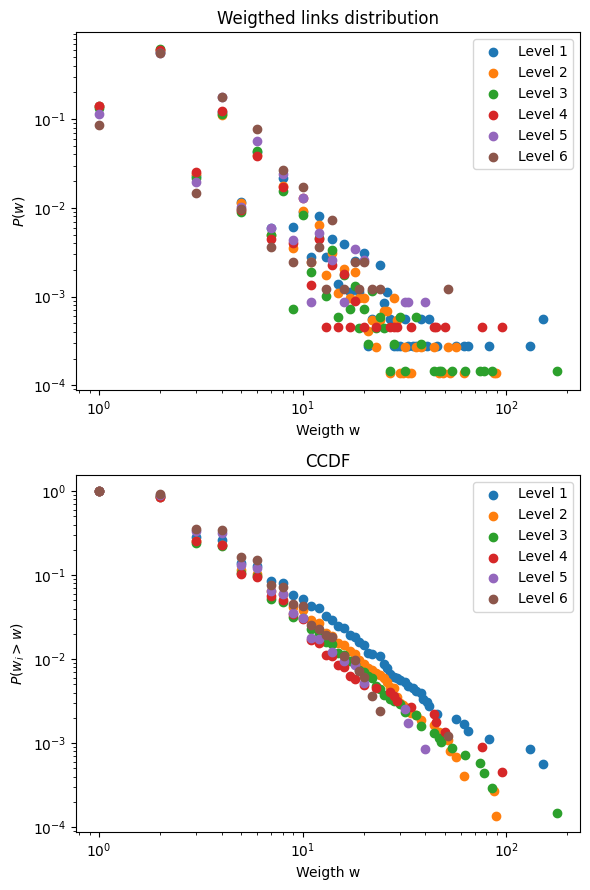

In [417]:
# Links weigth distribution per level

weigth_1, avg_w_1 = non_dir_weight(level_1_df)
weigth_2, avg_w_2 = non_dir_weight(level_2_df)
weigth_3, avg_w_3 = non_dir_weight(level_3_df)
weigth_4, avg_w_4 = non_dir_weight(level_4_df)
weigth_5, avg_w_5 = non_dir_weight(level_5_df)
weigth_6, avg_w_6 = non_dir_weight(level_6_df)

# Ploting the link's weigth distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))

ax[0].scatter(weigth_1[0], weigth_1[1], label='Level 1')
ax[0].scatter(weigth_2[0], weigth_2[1], label='Level 2')
ax[0].scatter(weigth_3[0], weigth_3[1], label='Level 3')
ax[0].scatter(weigth_4[0], weigth_4[1], label='Level 4')
ax[0].scatter(weigth_5[0], weigth_5[1], label='Level 5')
ax[0].scatter(weigth_6[0], weigth_6[1], label='Level 6')
# ax[0].vlines(k_1_avg, 0, max(degree_1[1]), label=r'$\langle k_1 \rangle$ = {}'.format(round(k_1_avg, 2)))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Weigth w')
ax[0].set_ylabel(r'$P(w)$')
ax[0].set_title('Weigthed links distribution')
ax[0].legend()

ax[1].scatter(weigth_1[0], weigth_1[2], label='Level 1')
ax[1].scatter(weigth_2[0], weigth_2[2], label='Level 2')
ax[1].scatter(weigth_3[0], weigth_3[2], label='Level 3')
ax[1].scatter(weigth_4[0], weigth_4[2], label='Level 4')
ax[1].scatter(weigth_5[0], weigth_5[2], label='Level 5')
ax[1].scatter(weigth_6[0], weigth_6[2], label='Level 6')
# ax[1].vlines(k_avg, 0, max(degree_dist[2]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Weigth w')
ax[1].set_ylabel(r'$P(w_i>w)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

In [418]:
# Showing the average weigth of the links per level
weigth_dict = {'Level 1': avg_w_1, 
               'Level 2': avg_w_2, 
               'Level 3': avg_w_3, 
               'Level 4': avg_w_4,
               'Level 5': avg_w_5,
               'Level 6': avg_w_6}
weigth_dict

{'Level 1': 3.4564791491743634,
 'Level 2': 3.0383569096844396,
 'Level 3': 2.9274686862802213,
 'Level 4': 2.911170928667564,
 'Level 5': 3.120822622107969,
 'Level 6': 3.3523693803159174}

### Gravitational Model

In [419]:
trips_1, theo_trips_1_1, theo_trips_2_1, theo_trips_3_1 = fiting_grav_models(level_1_df, counts_st_trips[0])
trips_2, theo_trips_1_2, theo_trips_2_2, theo_trips_3_2 = fiting_grav_models(level_2_df, counts_st_trips[1])
trips_3, theo_trips_1_3, theo_trips_2_3, theo_trips_3_3 = fiting_grav_models(level_3_df, counts_st_trips[2])
trips_4, theo_trips_1_4, theo_trips_2_4, theo_trips_3_4 = fiting_grav_models(level_4_df, counts_st_trips[3])
trips_5, theo_trips_1_5, theo_trips_2_5, theo_trips_3_5 = fiting_grav_models(level_5_df, counts_st_trips[4])
trips_6, theo_trips_1_6, theo_trips_2_6, theo_trips_3_6 = fiting_grav_models(level_6_df, counts_st_trips[5])

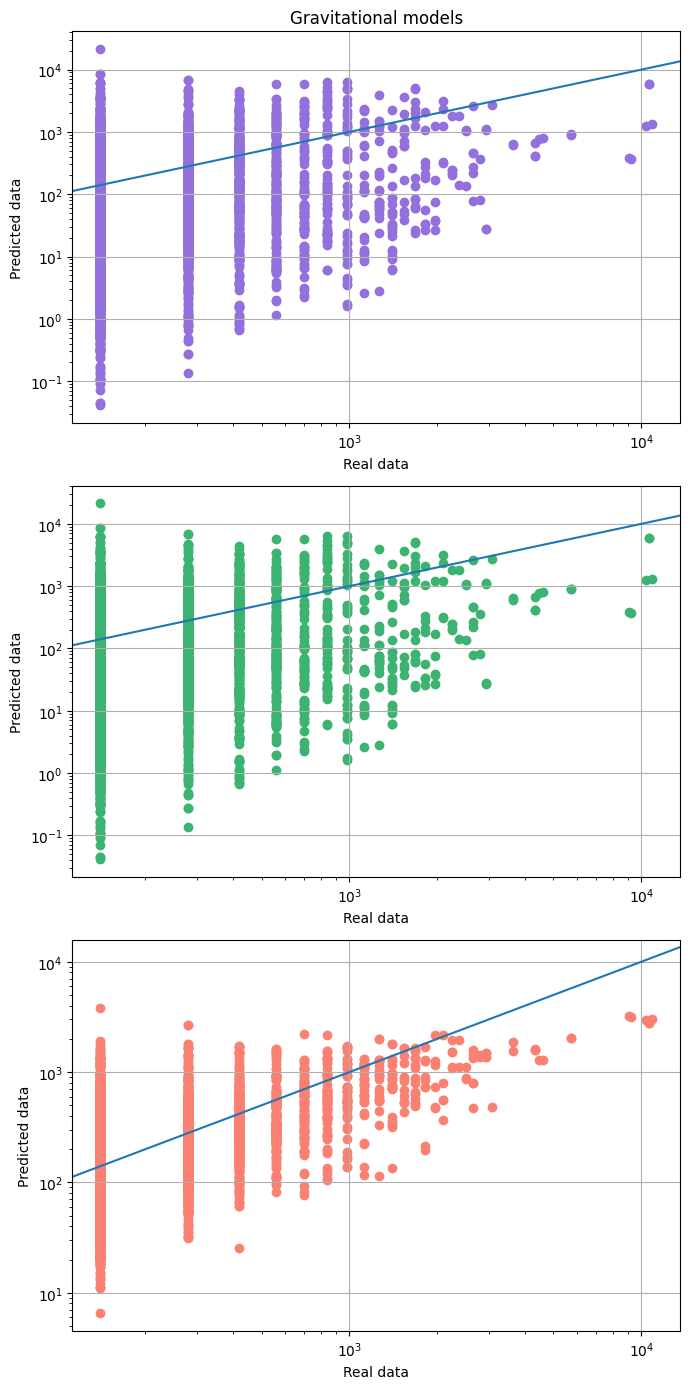

In [420]:
# Gravitational model for level 1
plot_real_theo_grav(trips_1, theo_trips_1_1, theo_trips_2_1, theo_trips_3_1)

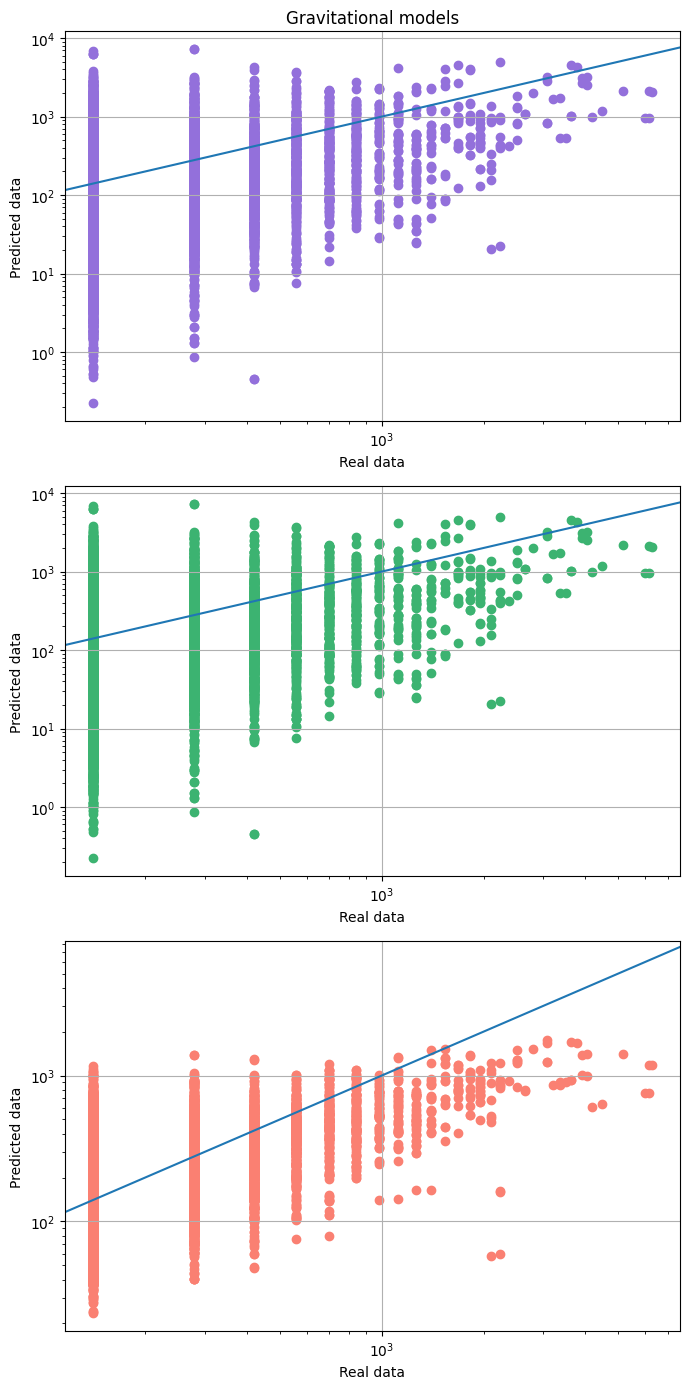

In [421]:
# Gravitational model for level 2
plot_real_theo_grav(trips_2, theo_trips_1_2, theo_trips_2_2, theo_trips_3_2)

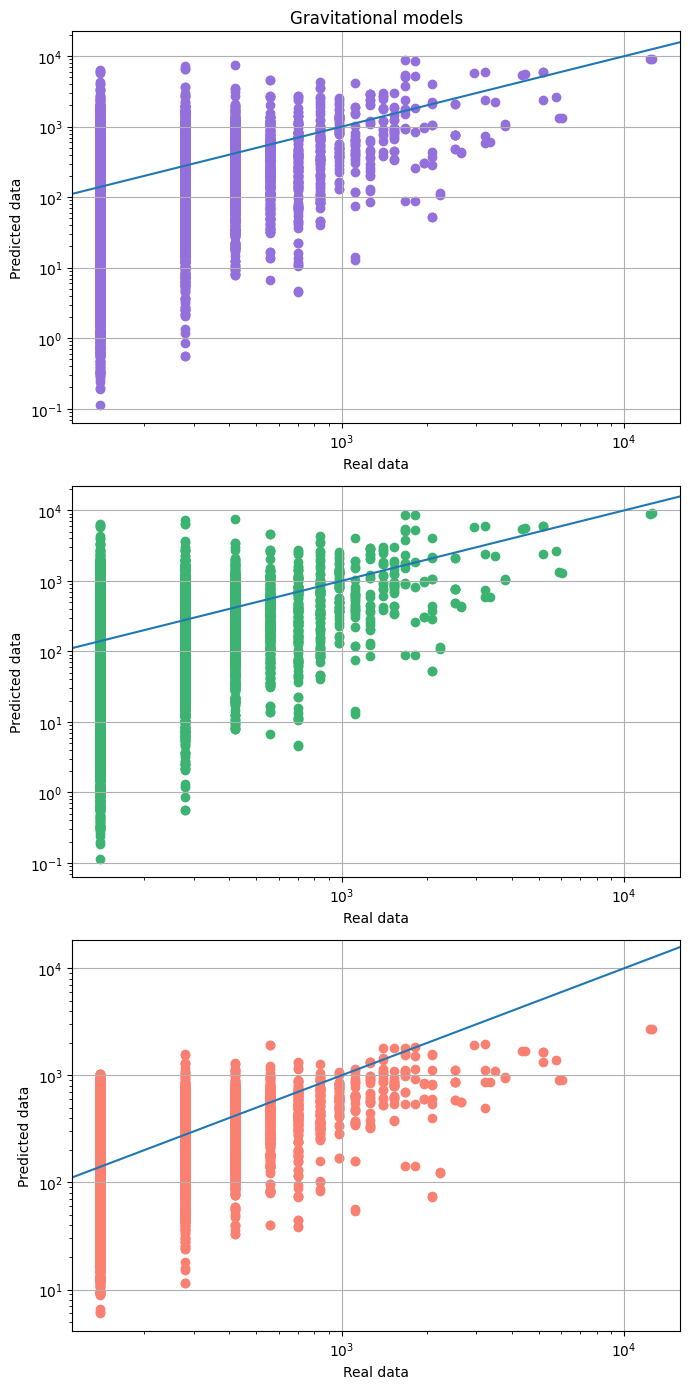

In [422]:
# Gravitational model for level 3
plot_real_theo_grav(trips_3, theo_trips_1_3, theo_trips_2_3, theo_trips_3_3)

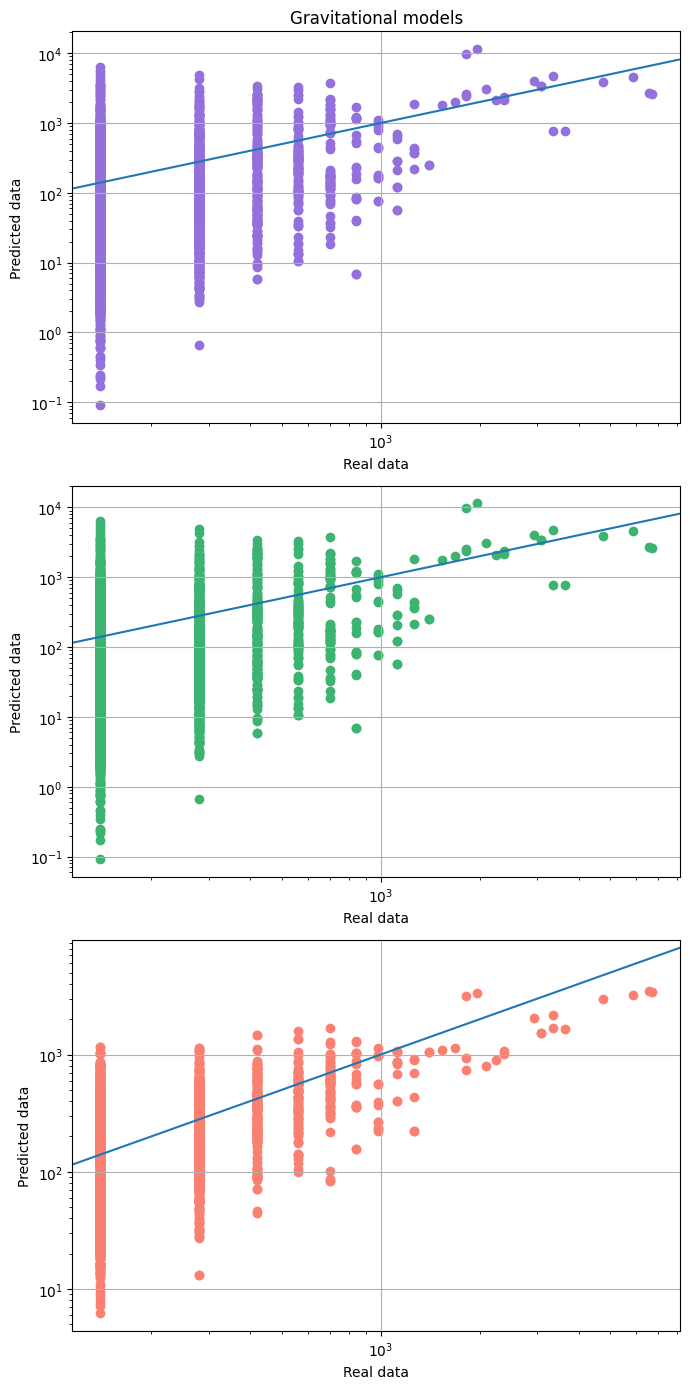

In [423]:
# Gravitational model for level 4
plot_real_theo_grav(trips_4, theo_trips_1_4, theo_trips_2_4, theo_trips_3_4)

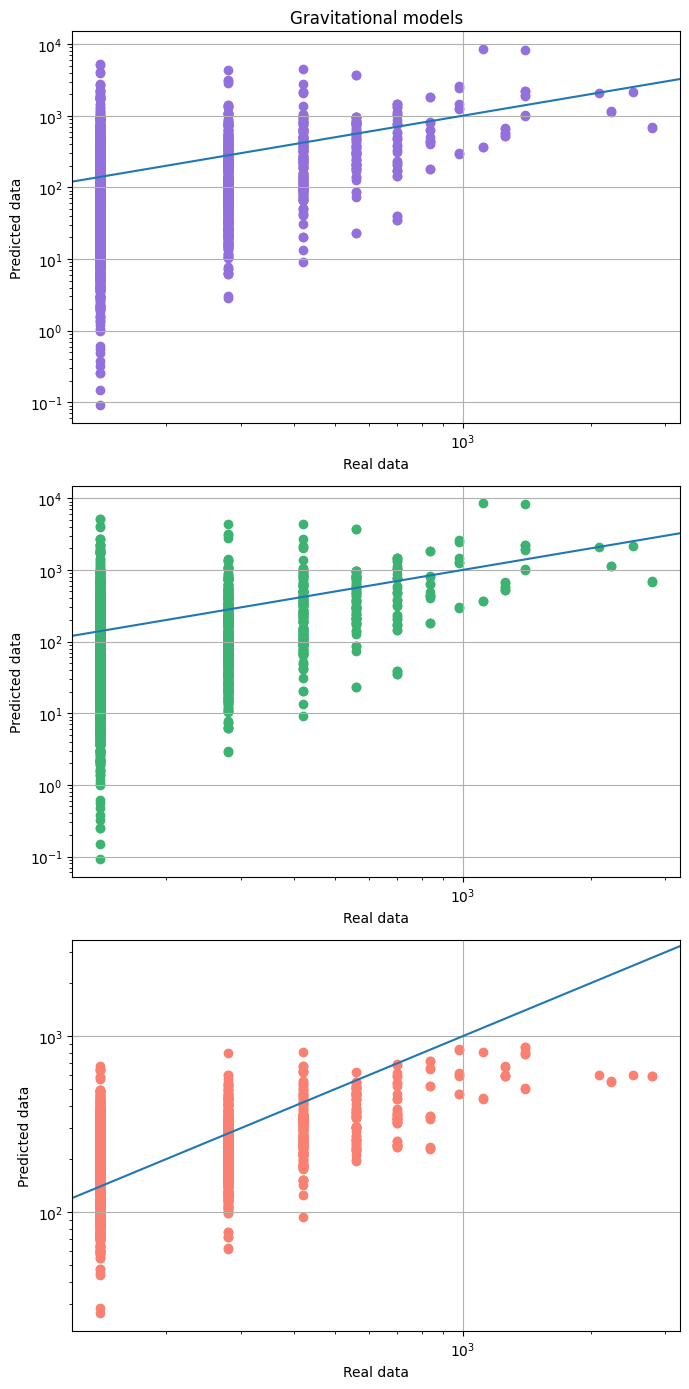

In [424]:
# Gravitational model for level 5
plot_real_theo_grav(trips_5, theo_trips_1_5, theo_trips_2_5, theo_trips_3_5)

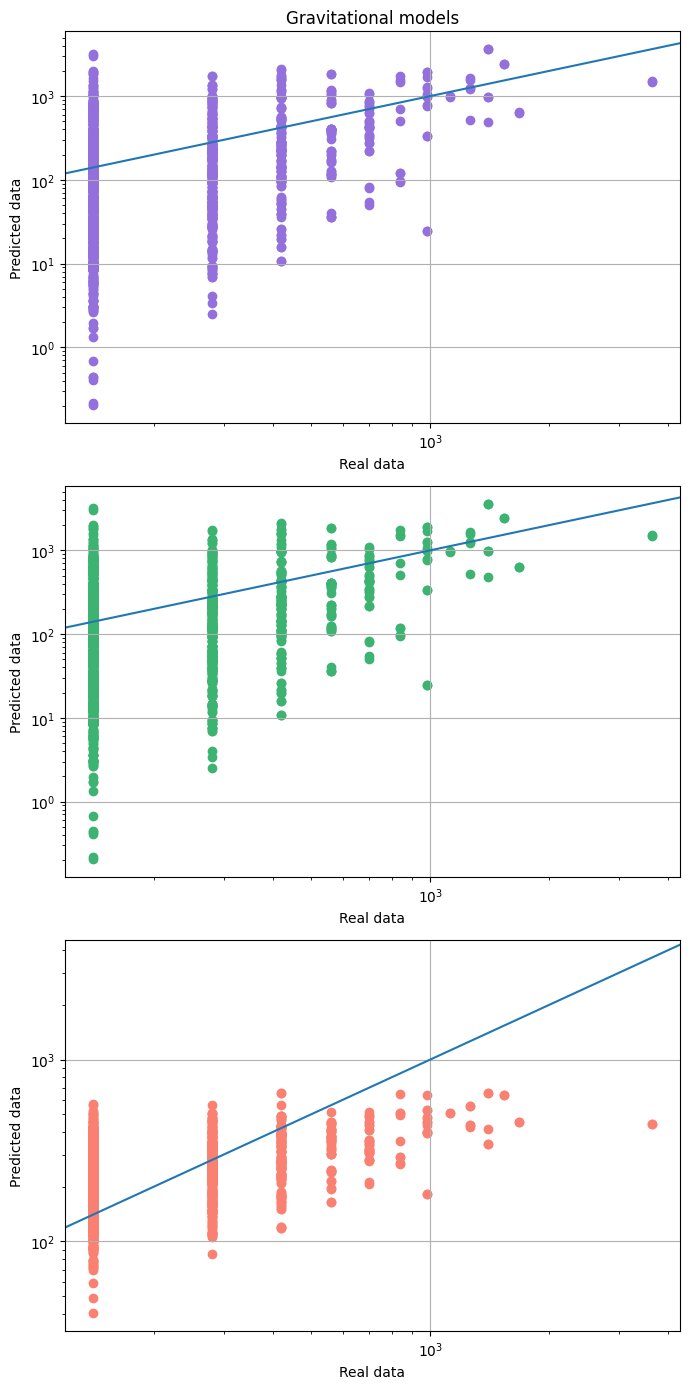

In [425]:
# Gravitational model for level 6
plot_real_theo_grav(trips_6, theo_trips_1_6, theo_trips_2_6, theo_trips_3_6)

### Radiation Model

In [426]:
# Computing the predicted values given by the radiation model for each socio economic level
T_ij_1 = net_radiation_model(level_1_df, counts_st_trips[0])
T_ij_2 = net_radiation_model(level_2_df, counts_st_trips[1])
T_ij_3 = net_radiation_model(level_3_df, counts_st_trips[2])
T_ij_4 = net_radiation_model(level_4_df, counts_st_trips[3])
T_ij_5 = net_radiation_model(level_5_df, counts_st_trips[4])
T_ij_6 = net_radiation_model(level_6_df, counts_st_trips[5])

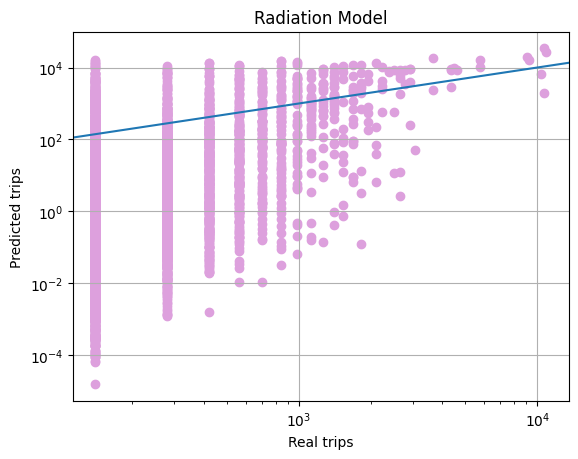

In [427]:
# Ploting the radiation model for the level 1
plot_radiation(level_1_df, T_ij_1, counts_st_trips[0])

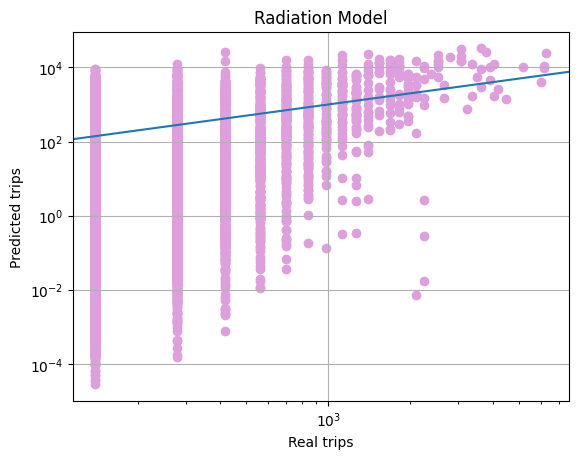

In [428]:
# Ploting the radiation model for the level 2
plot_radiation(level_2_df, T_ij_2, counts_st_trips[1])

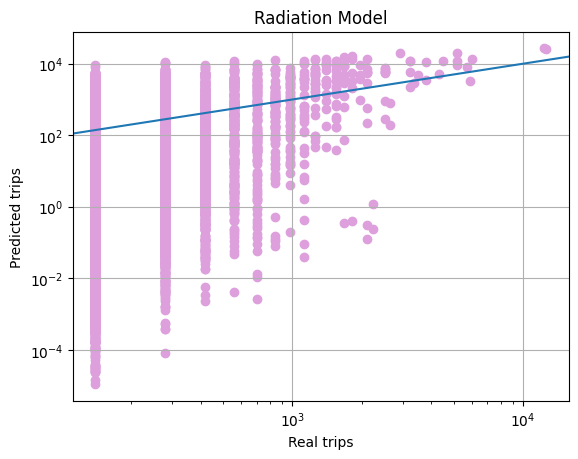

In [429]:
# Ploting the radiation model for the level 3
plot_radiation(level_3_df, T_ij_3, counts_st_trips[2])

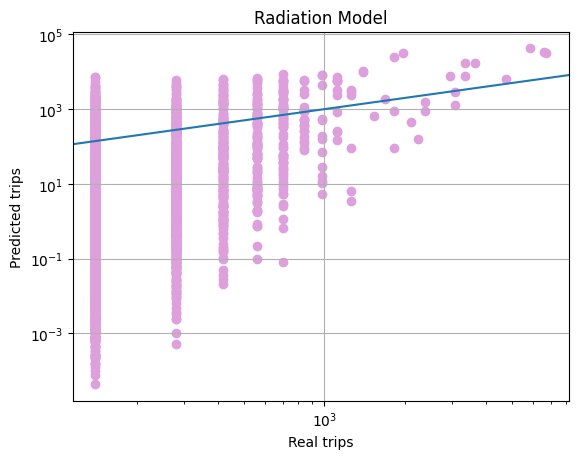

In [430]:
# Ploting the radiation model for the level 4
plot_radiation(level_4_df, T_ij_4, counts_st_trips[3])

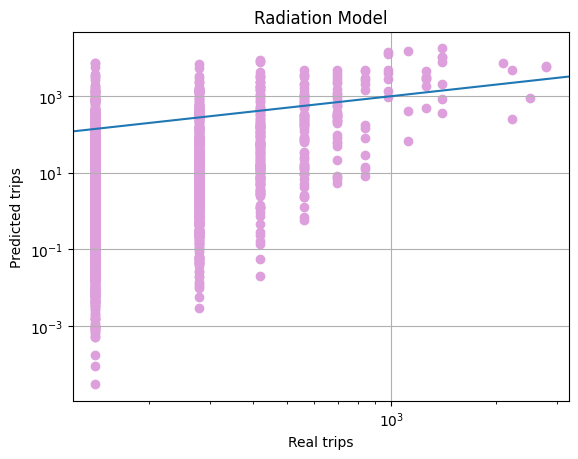

In [431]:
# Ploting the radiation model for the level 5
plot_radiation(level_5_df, T_ij_5, counts_st_trips[4])

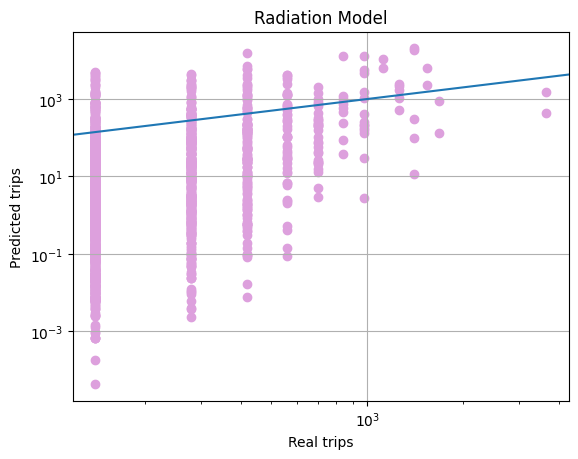

In [432]:
# Ploting the radiation model for the level 6
plot_radiation(level_6_df, T_ij_6, counts_st_trips[5])

### Correlations per strata

En esta sección se estudia la dependencía de numero de viajeros entre zonas en función de la distancia, comparando los modelos con los datos reales para cada uno de los estratos

In [448]:
# Creating the dataframes with all the information of the models
def correlation_df(df, frac, trips, grav_trips_1, grav_trips_2, grav_trips_3, rad_model):
    dst = np.array(df['Distances'])
    dst = convert_values(dst)
    s_in = np.array(df['Destination Trips'])*(10.2e6*frac)/sum(df['Destination Trips'])
    corr = {'Real Trips': trips, 'Distances': dst, r's_j_in': s_in,'Gravity 1': grav_trips_1, 'Gravity 2': grav_trips_2, 'Gravity 3': grav_trips_3, 'Radiation': rad_model}
    corr = pd.DataFrame(corr)
    columns = ['Real Trips', 'Gravity 1', 'Gravity 2', 'Gravity 3', 'Radiation']
    corr_dis_mean = (corr.groupby('Distances', as_index=False)[columns]
                    .agg('mean')
                    .sort_values(by='Distances'))
    corr_si_mean = (corr.groupby('s_j_in', as_index=False)[columns]
                    .agg('mean')
                    .sort_values(by='s_j_in'))
    return corr_dis_mean, corr_si_mean

# Creating the correlation df for each of the strata levels
corr_1_dis, corr_1_s = correlation_df(level_1_df, counts_st_trips[0], trips_1, theo_trips_1_1, theo_trips_2_1, theo_trips_3_1, T_ij_1)
corr_2_dis, corr_2_s = correlation_df(level_2_df, counts_st_trips[1], trips_2, theo_trips_1_2, theo_trips_2_2, theo_trips_3_2, T_ij_2)
corr_3_dis, corr_3_s = correlation_df(level_3_df, counts_st_trips[2], trips_3, theo_trips_1_3, theo_trips_2_3, theo_trips_3_3, T_ij_3)
corr_4_dis, corr_4_s = correlation_df(level_4_df, counts_st_trips[3], trips_4, theo_trips_1_4, theo_trips_2_4, theo_trips_3_4, T_ij_4)
corr_5_dis, corr_5_s = correlation_df(level_5_df, counts_st_trips[4], trips_5, theo_trips_1_5, theo_trips_2_5, theo_trips_3_5, T_ij_5)
corr_6_dis, corr_6_s = correlation_df(level_6_df, counts_st_trips[5], trips_6, theo_trips_1_6, theo_trips_2_6, theo_trips_3_6, T_ij_6)

# Function that plots the correlations
def plot_corr(corr_dist):
    plt.figure()
    plt.scatter(corr_dist['Distances'], corr_dist['Real Trips'], label='Real Trips')
    plt.plot(corr_dist['Distances'], corr_dist['Real Trips'])
    plt.scatter(corr_dist['Distances'], corr_dist['Gravity 1'], label='Gravity 1', color='mediumpurple')
    plt.plot(corr_dist['Distances'], corr_dist['Gravity 1'], color='mediumpurple')
    plt.scatter(corr_dist['Distances'], corr_dist['Gravity 2'], label='Gravity 2', color='mediumseagreen')
    plt.plot(corr_dist['Distances'], corr_dist['Gravity 2'], color='mediumseagreen')
    plt.scatter(corr_dist['Distances'], corr_dist['Gravity 3'], label='Gravity 3', color='salmon')
    plt.plot(corr_dist['Distances'], corr_dist['Gravity 3'], color='salmon')
    plt.scatter(corr_dist['Distances'], corr_dist['Radiation'], label='Radiation', color='plum')
    plt.plot(corr_dist['Distances'], corr_dist['Radiation'], color='plum')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Distance r', fontsize=13)
    plt.ylabel(r'$\langle T_{ij} \rangle$', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()

def plot_corr_s_i(corr_s_i):
    plt.figure()
    plt.scatter(corr_s_i['s_j_in'], corr_s_i['Real Trips'], label='Real Trips')
    plt.scatter(corr_s_i['s_j_in'], corr_s_i['Gravity 1'], label='Gravity 1', color='mediumpurple')
    plt.scatter(corr_s_i['s_j_in'], corr_s_i['Gravity 2'], label='Gravity 2', color='mediumseagreen')
    plt.scatter(corr_s_i['s_j_in'], corr_s_i['Gravity 3'], label='Gravity 3', color='salmon')
    plt.scatter(corr_s_i['s_j_in'], corr_s_i['Radiation'], label='Radiation', color='plum')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$s_j^{in}$', fontsize=15)
    plt.ylabel(r'$\langle T_{ij} \rangle$', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()

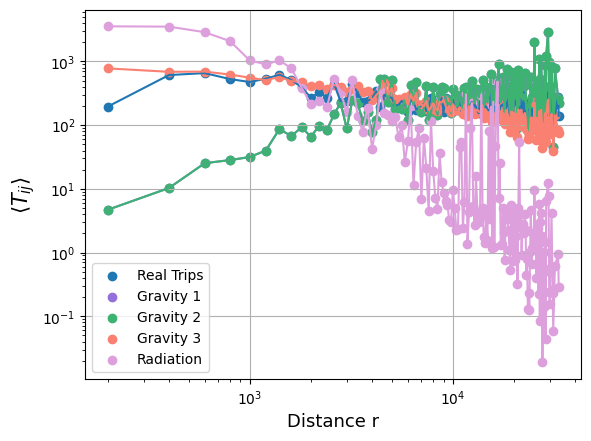

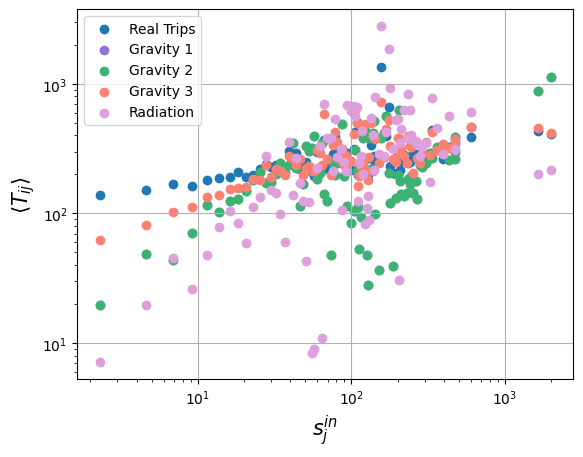

In [449]:
# Ploting the correlations for level 1
plot_corr(corr_1_dis)
plot_corr_s_i(corr_1_s)

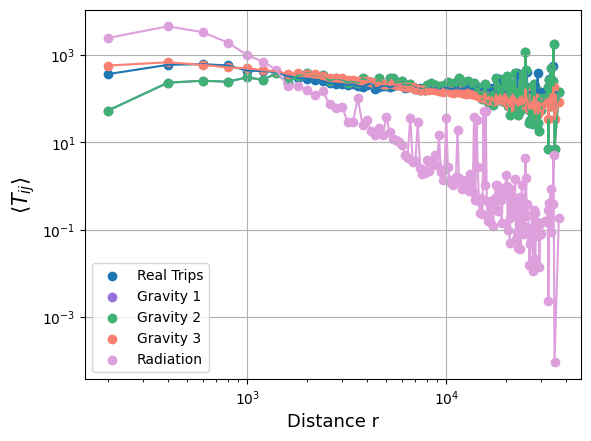

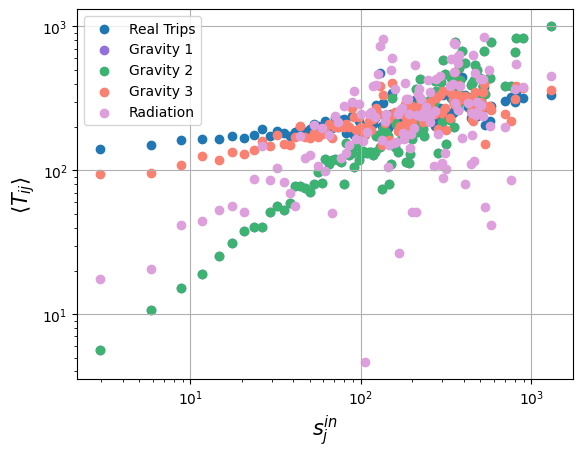

In [450]:
# Ploting the correlations for level 2
plot_corr(corr_2_dis)
plot_corr_s_i(corr_2_s)

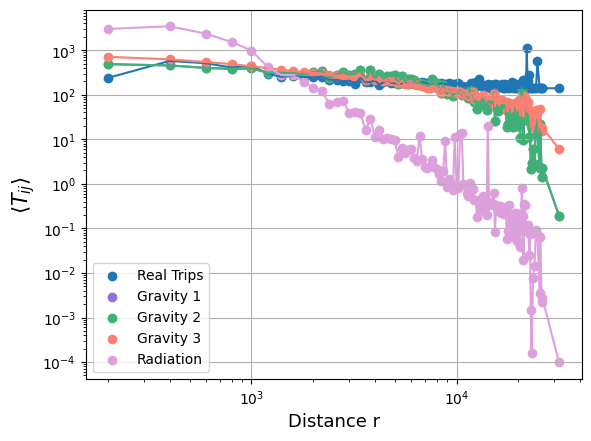

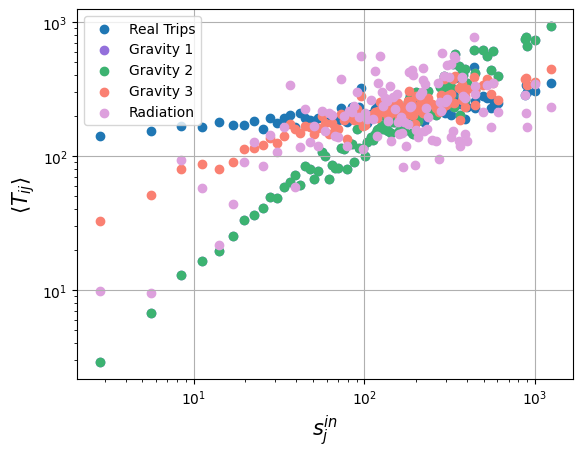

In [451]:
# Ploting the correlations for level 3
plot_corr(corr_3_dis)
plot_corr_s_i(corr_3_s)

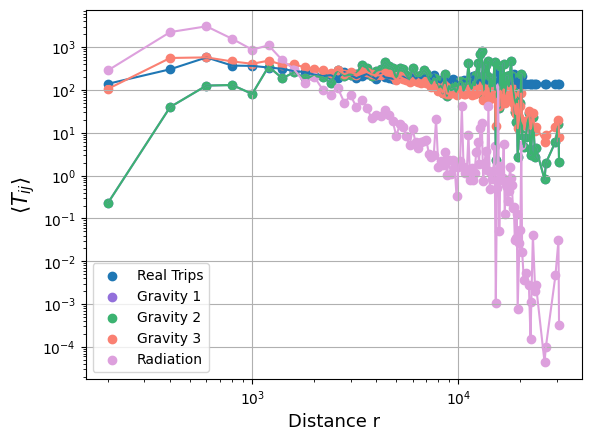

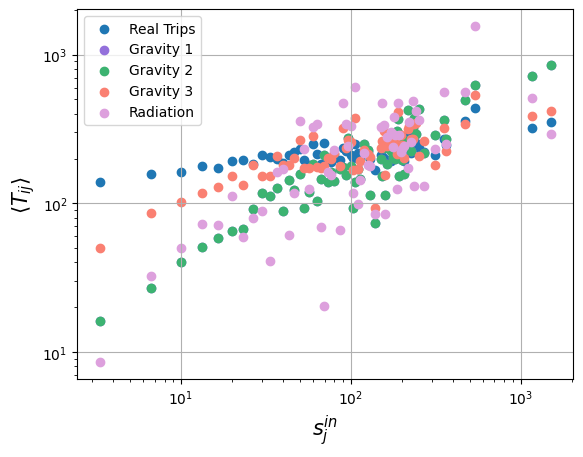

In [452]:
# Ploting the correlations for level 4
plot_corr(corr_4_dis)
plot_corr_s_i(corr_4_s)

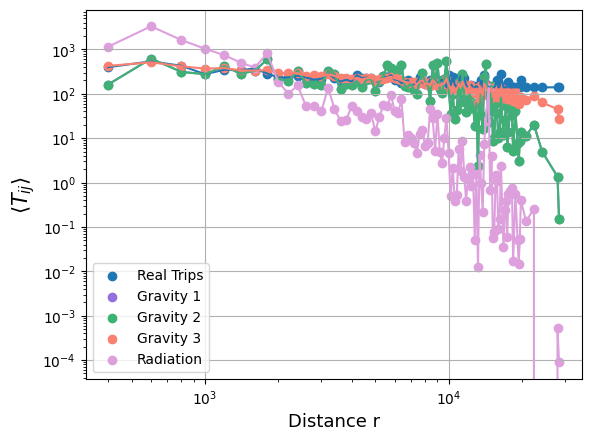

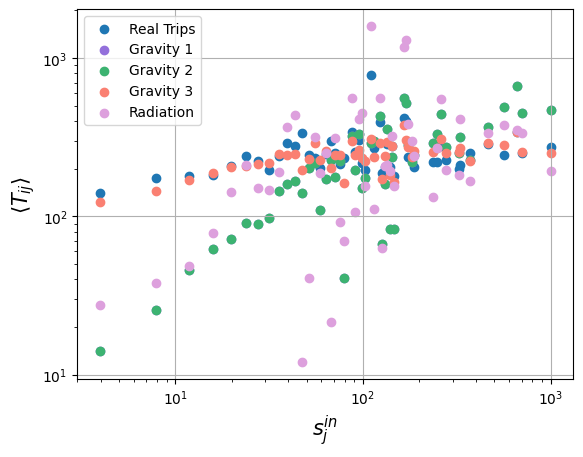

In [453]:
# Ploting the correlations for level 5
plot_corr(corr_5_dis)
plot_corr_s_i(corr_5_s)

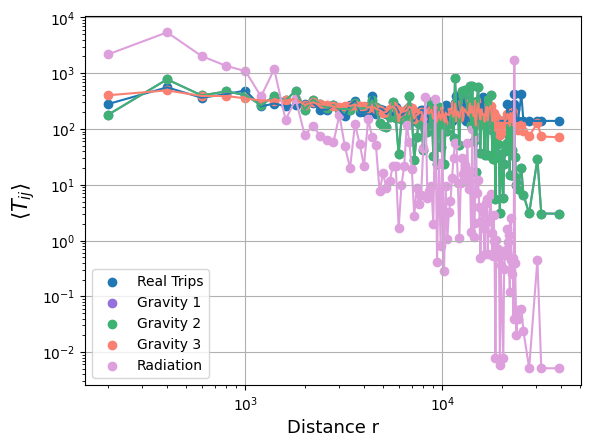

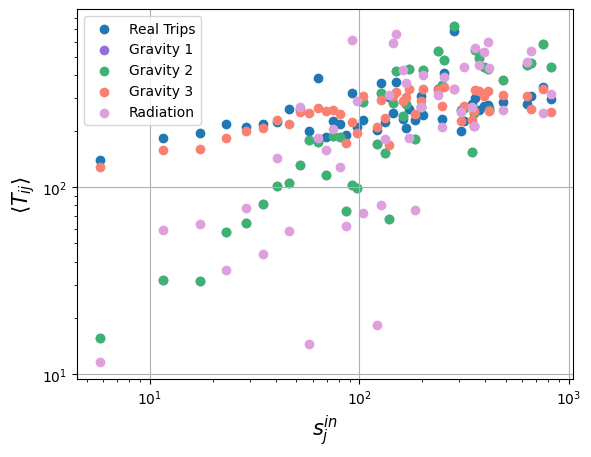

In [454]:
# Ploting the correlations for level 6
plot_corr(corr_6_dis)
plot_corr_s_i(corr_6_s)

## Eliminate trips

En esta sección se tiene el proposito de eliminar aquellos edges que solo cuentan con un viajero registrado, y realizar todas las medidas hechas anteriormente,

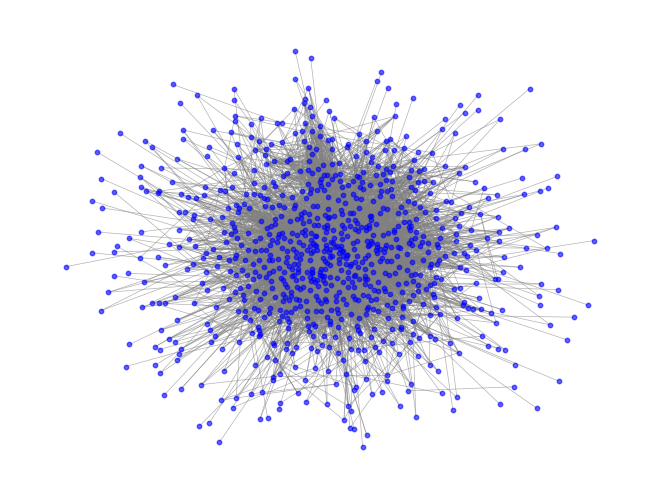

In [67]:
# Filtering the trips that have more than one registred trip 
num_dis_1 = num_dis_trips[num_dis_trips['Trips']>1]

# Vizualizing the network and saving the edge list
edge_1 = num_dis_1[['zat_ori', 'zat_des']]
G_1_bogota = nx.from_pandas_edgelist(edge_1, 'zat_ori', 'zat_des')

# Ploting the network 
pos = nx.spring_layout(G_1_bogota, k=0.15, iterations=20)
nx.draw(G_1_bogota, pos, node_size=10, node_color='blue', alpha=0.6, edge_color='gray', width=0.5)
plt.show()

### Non directed Network

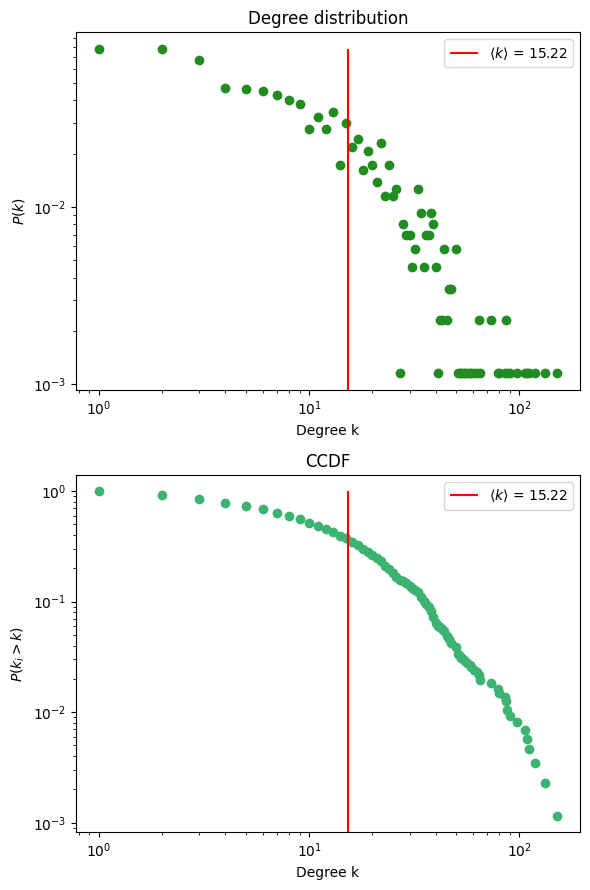

In [68]:
degree_dist, k_avg = non_dir_degree(num_dis_1)

# Ploting the degree distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(degree_dist[0], degree_dist[1], color = 'forestgreen')
ax[0].vlines(k_avg, 0, max(degree_dist[1]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Degree k')
ax[0].set_ylabel(r'$P(k)$')
ax[0].set_title('Degree distribution')
ax[0].legend()

ax[1].scatter(degree_dist[0], degree_dist[2], color = 'mediumseagreen')
ax[1].vlines(k_avg, 0, max(degree_dist[2]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Degree k')
ax[1].set_ylabel(r'$P(k_i>k)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

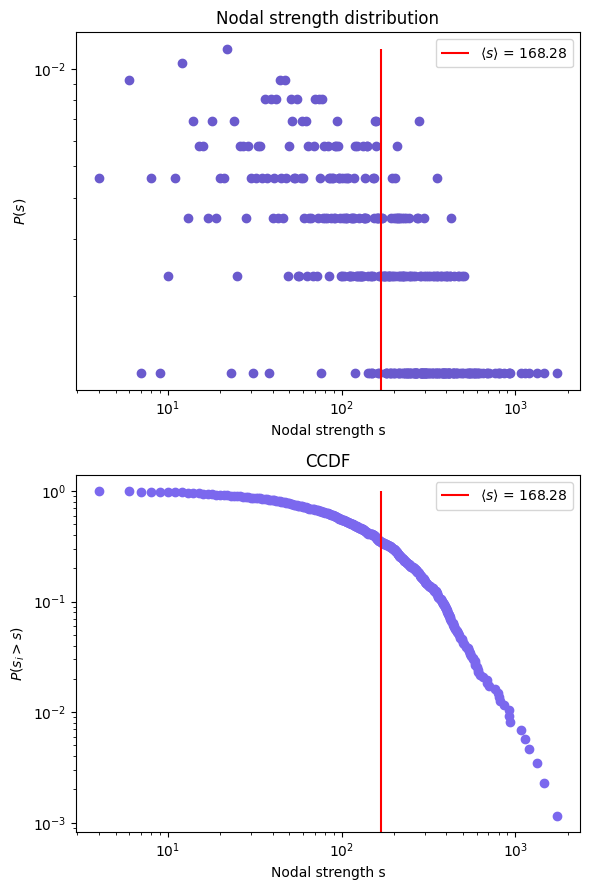

In [69]:
str_dist, str_avg = non_dir_strength(num_dis_1)

# Ploting the nodal strength distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(str_dist[0], str_dist[1], color = 'slateblue')
ax[0].vlines(str_avg, 0, max(str_dist[1]), label=r'$\langle s \rangle$ = {}'.format(round(str_avg, 2)), color='r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Nodal strength s')
ax[0].set_ylabel(r'$P(s)$')
ax[0].set_title('Nodal strength distribution')
ax[0].legend()

ax[1].scatter(str_dist[0], str_dist[2], color = 'mediumslateblue')
ax[1].vlines(str_avg, 0, max(str_dist[2]), label=r'$\langle s \rangle$ = {}'.format(round(str_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Nodal strength s')
ax[1].set_ylabel(r'$P(s_i>s)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

### Directed network

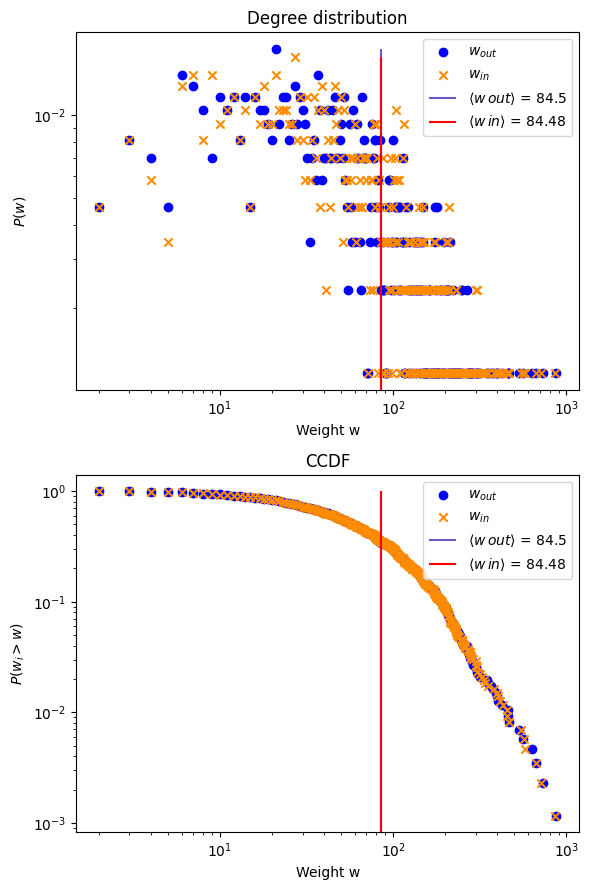

In [70]:
# Computing the deistribution for the in out strength dist and the directed link's weight

out_w_dis, out_w_avg, in_w_dis, in_w_avg = in_out_strength(num_dis_1)

# out_w_dis, out_w_avg = dist_and_ccdf(num_dis_trips['Origin Trips'])
# in_w_dis, in_w_avg = dist_and_ccdf(num_dis_trips['Destination Trips'])

# Ploting the degree distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(out_w_dis[0], out_w_dis[1], color = 'b', label=r'$w_{out}$')
ax[0].scatter(in_w_dis[0], in_w_dis[1], color = 'darkorange', marker='x', label=r'$w_{in}$')
ax[0].vlines(out_w_avg, 0, max(out_w_dis[1]), label=r'$\langle w \, out \rangle$ = {}'.format(round(out_w_avg, 2)), color='slateblue')
ax[0].vlines(in_w_avg, 0, max(in_w_dis[1]), label=r'$\langle w \, in \rangle$ = {}'.format(round(in_w_avg, 2)), color='r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Weight w')
ax[0].set_ylabel(r'$P(w)$')
ax[0].set_title('Degree distribution')
ax[0].legend()

ax[1].scatter(out_w_dis[0], out_w_dis[2], color = 'b', label=r'$w_{out}$')
ax[1].scatter(in_w_dis[0], in_w_dis[2], color = 'darkorange', marker='x', label=r'$w_{in}$')
ax[1].vlines(out_w_avg, 0, max(out_w_dis[2]), label=r'$\langle w \, out \rangle$ = {}'.format(round(out_w_avg, 2)), color='slateblue')
ax[1].vlines(in_w_avg, 0, max(in_w_dis[2]), label=r'$\langle w \, in \rangle$ = {}'.format(round(in_w_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Weight w')
ax[1].set_ylabel(r'$P(w_i>w)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

### Gravitational Model

In [71]:
trips, theo_trips_1, theo_trips_2, theo_trips_3 = fiting_grav_models(num_dis_1)
plot_real_theo_grav(trips, theo_trips_1, theo_trips_2, theo_trips_3)

TypeError: fiting_grav_models() missing 1 required positional argument: 'frac'

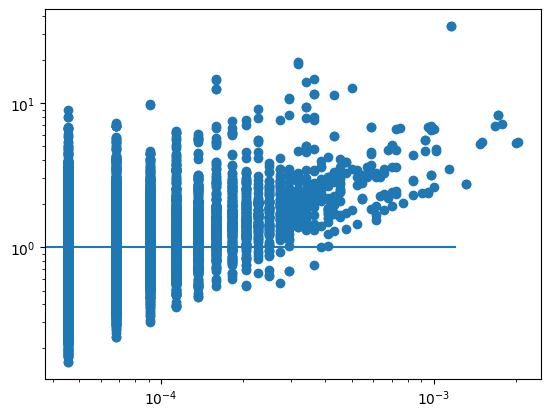

In [ ]:
# Variability

plt.scatter(trips, trips/theo_trips_3)
plt.hlines(1, xmin=0, xmax=0.0012)
plt.xscale('log')
plt.yscale('log')

### Radiation Model

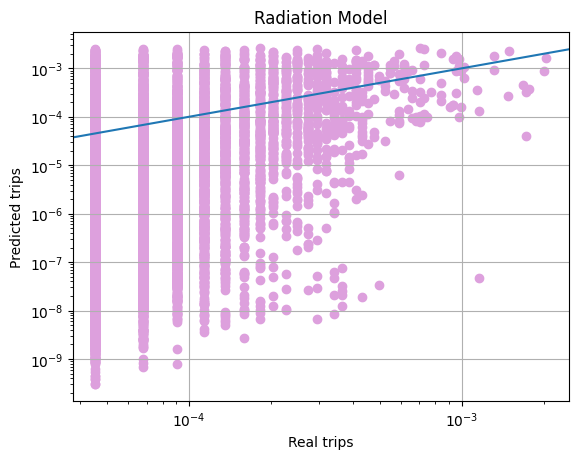

In [ ]:
T_ij = radiation_model(num_dis_1)
plot_radiation(num_dis_1, T_ij)

### Analysis per Socio-Economic level

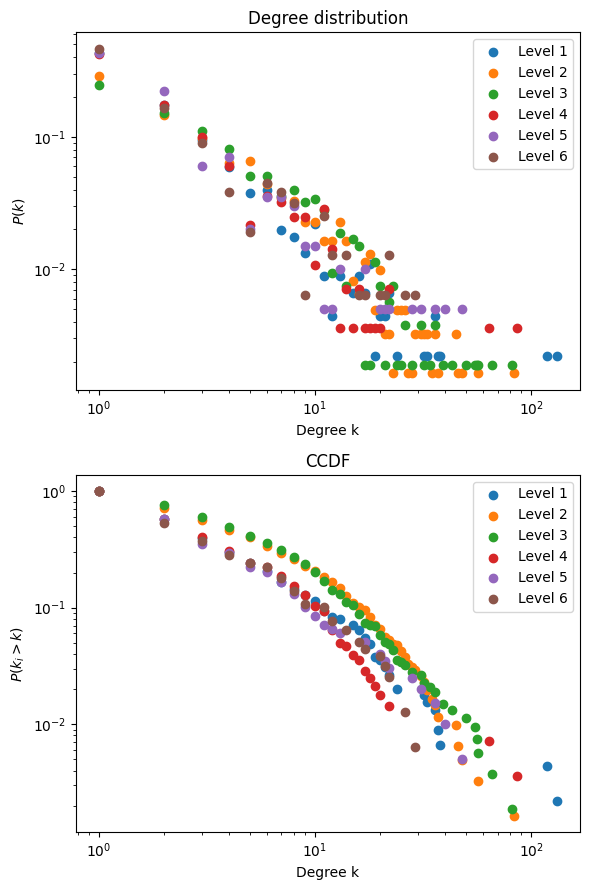

In [ ]:
# Filtering the data per each strata
level_1_df = level_1_df[level_1_df['Trips']>1]
level_2_df = level_2_df[level_2_df['Trips']>1]
level_3_df = level_3_df[level_3_df['Trips']>1]
level_4_df = level_4_df[level_4_df['Trips']>1]
level_5_df = level_5_df[level_5_df['Trips']>1]
level_6_df = level_6_df[level_6_df['Trips']>1]

# Mesuring the degree dist of each level network
degree_1, k_1_avg = non_dir_degree(level_1_df)
degree_2, k_2_avg = non_dir_degree(level_2_df)
degree_3, k_3_avg = non_dir_degree(level_3_df)
degree_4, k_4_avg = non_dir_degree(level_4_df)
degree_5, k_5_avg = non_dir_degree(level_5_df)
degree_6, k_6_avg = non_dir_degree(level_6_df)

# Ploting the degree distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(degree_1[0], degree_1[1], label='Level 1')
ax[0].scatter(degree_2[0], degree_2[1], label='Level 2')
ax[0].scatter(degree_3[0], degree_3[1], label='Level 3')
ax[0].scatter(degree_4[0], degree_4[1], label='Level 4')
ax[0].scatter(degree_5[0], degree_5[1], label='Level 5')
ax[0].scatter(degree_6[0], degree_6[1], label='Level 6')
# ax[0].vlines(k_1_avg, 0, max(degree_1[1]), label=r'$\langle k_1 \rangle$ = {}'.format(round(k_1_avg, 2)))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Degree k')
ax[0].set_ylabel(r'$P(k)$')
ax[0].set_title('Degree distribution')
ax[0].legend()

ax[1].scatter(degree_1[0], degree_1[2], label='Level 1')
ax[1].scatter(degree_2[0], degree_2[2], label='Level 2')
ax[1].scatter(degree_3[0], degree_3[2], label='Level 3')
ax[1].scatter(degree_4[0], degree_4[2], label='Level 4')
ax[1].scatter(degree_5[0], degree_5[2], label='Level 5')
ax[1].scatter(degree_6[0], degree_6[2], label='Level 6')
# ax[1].vlines(k_avg, 0, max(degree_dist[2]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Degree k')
ax[1].set_ylabel(r'$P(k_i>k)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Showing the average degree per level
degree_dict = {'Level 1': k_1_avg, 
               'Level 2': k_2_avg, 
               'Level 3': k_3_avg, 
               'Level 4': k_4_avg,
               'Level 5': k_5_avg,
               'Level 6': k_6_avg}
degree_dict

{'Level 1': 4.60485651214128,
 'Level 2': 6.313725490196078,
 'Level 3': 6.447368421052632,
 'Level 4': 4.15,
 'Level 5': 4.0703517587939695,
 'Level 6': 3.872611464968153}

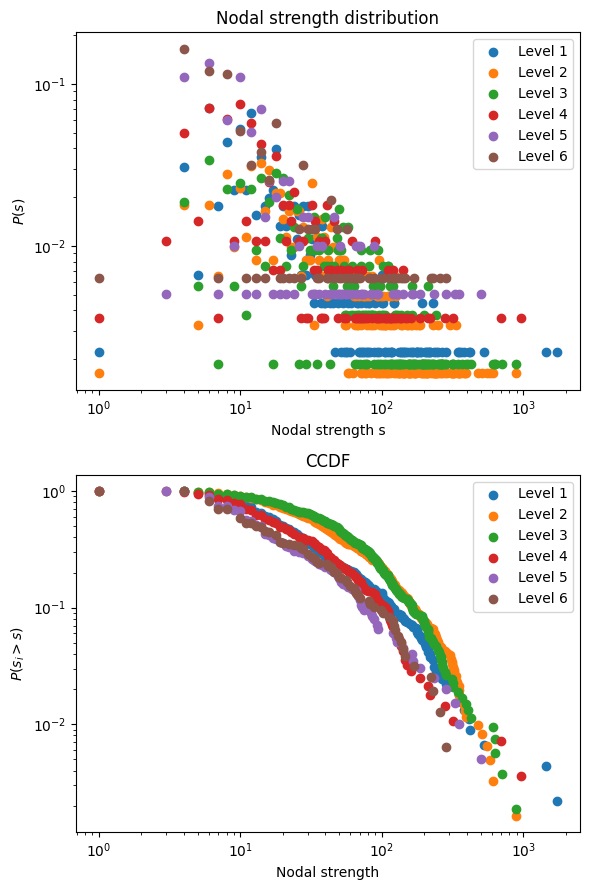

In [ ]:
strength_1, avg_str_1 = non_dir_strength(level_1_df)
strength_2, avg_str_2 = non_dir_strength(level_2_df)
strength_3, avg_str_3 = non_dir_strength(level_3_df)
strength_4, avg_str_4 = non_dir_strength(level_4_df)
strength_5, avg_str_5 = non_dir_strength(level_5_df)
strength_6, avg_str_6 = non_dir_strength(level_6_df)

# Ploting the nodal strength distribution and the CCDF
fig, ax = plt.subplots(2, figsize=(6,9))
ax[0].scatter(strength_1[0], strength_1[1], label='Level 1')
ax[0].scatter(strength_2[0], strength_2[1], label='Level 2')
ax[0].scatter(strength_3[0], strength_3[1], label='Level 3')
ax[0].scatter(strength_4[0], strength_4[1], label='Level 4')
ax[0].scatter(strength_5[0], strength_5[1], label='Level 5')
ax[0].scatter(strength_6[0], strength_6[1], label='Level 6')
# ax[0].vlines(k_1_avg, 0, max(degree_1[1]), label=r'$\langle k_1 \rangle$ = {}'.format(round(k_1_avg, 2)))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Nodal strength s')
ax[0].set_ylabel(r'$P(s)$')
ax[0].set_title('Nodal strength distribution')
ax[0].legend()

ax[1].scatter(strength_1[0], strength_1[2], label='Level 1')
ax[1].scatter(strength_2[0], strength_2[2], label='Level 2')
ax[1].scatter(strength_3[0], strength_3[2], label='Level 3')
ax[1].scatter(strength_4[0], strength_4[2], label='Level 4')
ax[1].scatter(strength_5[0], strength_5[2], label='Level 5')
ax[1].scatter(strength_6[0], strength_6[2], label='Level 6')
# ax[1].vlines(k_avg, 0, max(degree_dist[2]), label=r'$\langle k \rangle$ = {}'.format(round(k_avg, 2)), color='r')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Nodal strength')
ax[1].set_ylabel(r'$P(s_i>s)$')
ax[1].set_title('CCDF')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Showing the average strength per level
strength_dict = {'Level 1': avg_str_1, 
               'Level 2': avg_str_2, 
               'Level 3': avg_str_3, 
               'Level 4': avg_str_4,
               'Level 5': avg_str_5,
               'Level 6': avg_str_6}
strength_dict

{'Level 1': 51.88741721854305,
 'Level 2': 70.72712418300654,
 'Level 3': 72.94736842105263,
 'Level 4': 42.7,
 'Level 5': 33.60301507537689,
 'Level 6': 32.46496815286624}

In [ ]:
# Gravitational model

trips_1, theo_trips_1_1, theo_trips_2_1, theo_trips_3_1 = fiting_grav_models(level_1_df)
trips_2, theo_trips_1_2, theo_trips_2_2, theo_trips_3_2 = fiting_grav_models(level_2_df)
trips_3, theo_trips_1_3, theo_trips_2_3, theo_trips_3_3 = fiting_grav_models(level_3_df)
trips_4, theo_trips_1_4, theo_trips_2_4, theo_trips_3_4 = fiting_grav_models(level_4_df)
trips_5, theo_trips_1_5, theo_trips_2_5, theo_trips_3_5 = fiting_grav_models(level_5_df)
trips_6, theo_trips_1_6, theo_trips_2_6, theo_trips_3_6 = fiting_grav_models(level_6_df)

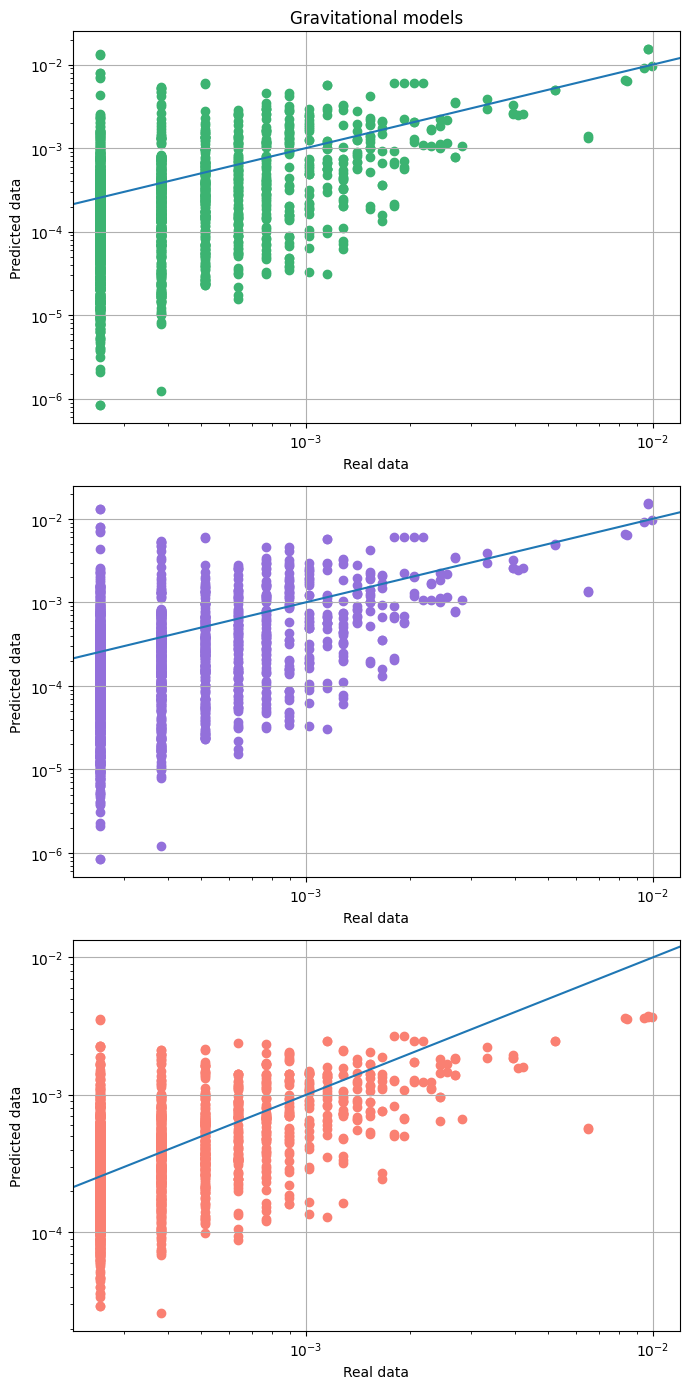

In [ ]:
# Gravitational model for level 1
plot_real_theo_grav(trips_1, theo_trips_1_1, theo_trips_2_1, theo_trips_3_1)

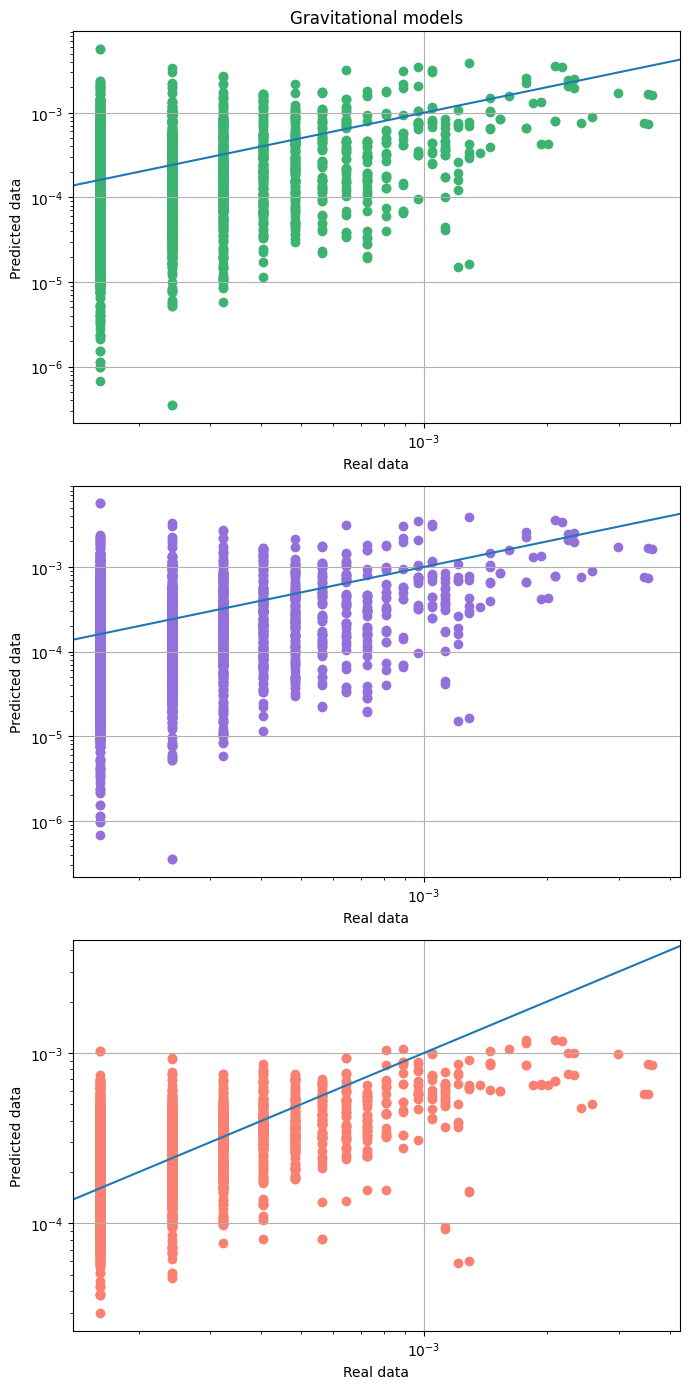

In [ ]:
# Gravitational model for level 2
plot_real_theo_grav(trips_2, theo_trips_1_2, theo_trips_2_2, theo_trips_3_2)

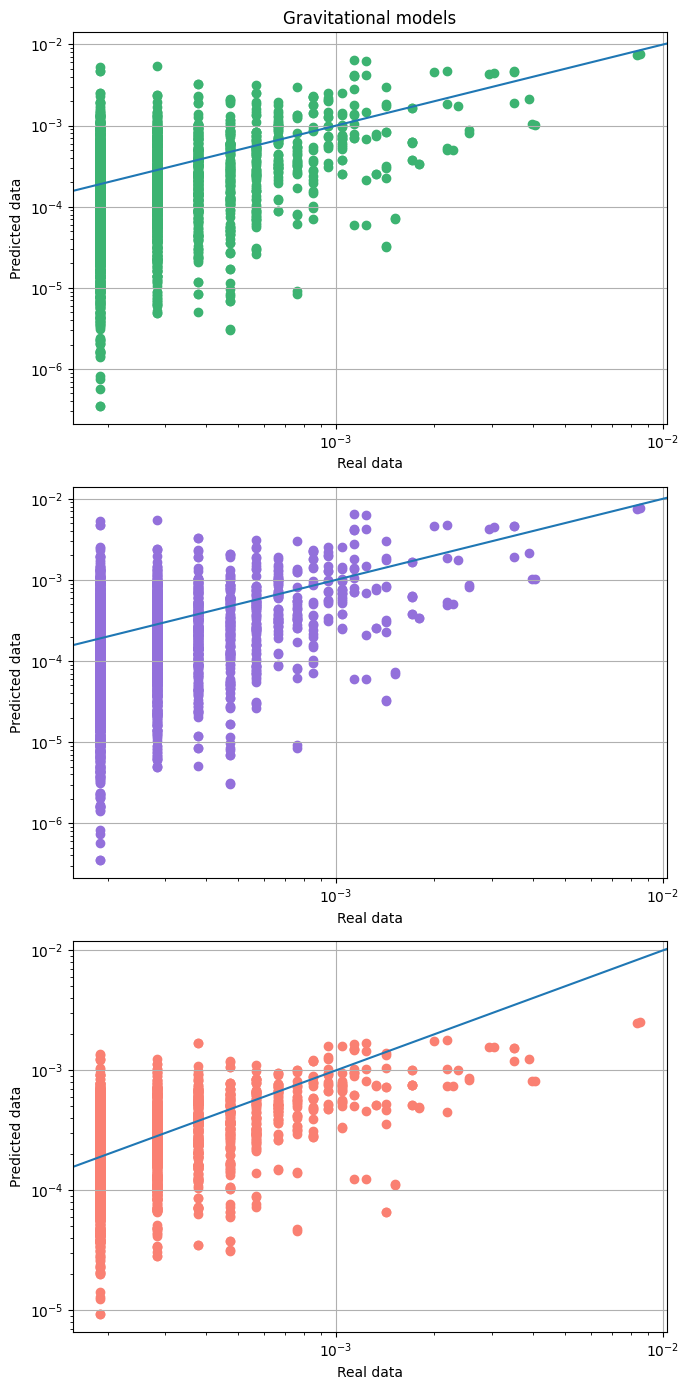

In [ ]:
# Gravitational model for level 3
plot_real_theo_grav(trips_3, theo_trips_1_3, theo_trips_2_3, theo_trips_3_3)

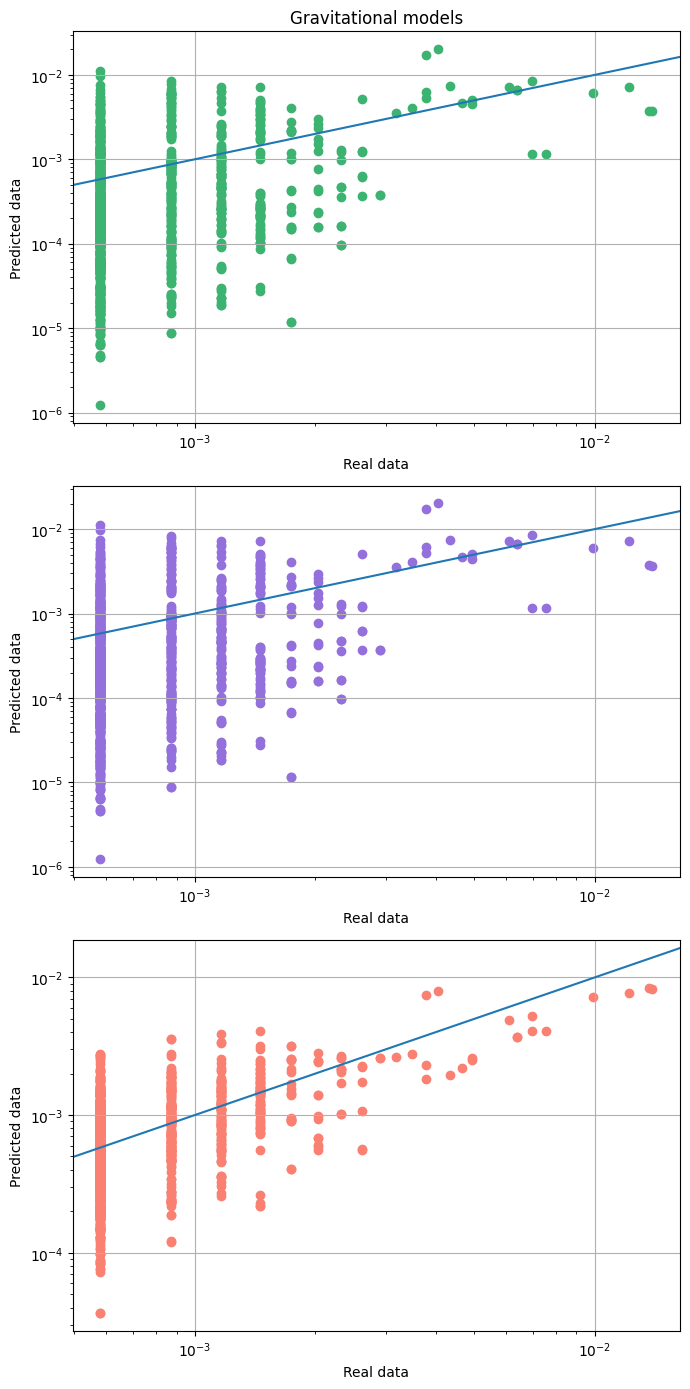

In [ ]:
# Gravitational model for level 4
plot_real_theo_grav(trips_4, theo_trips_1_4, theo_trips_2_4, theo_trips_3_4)

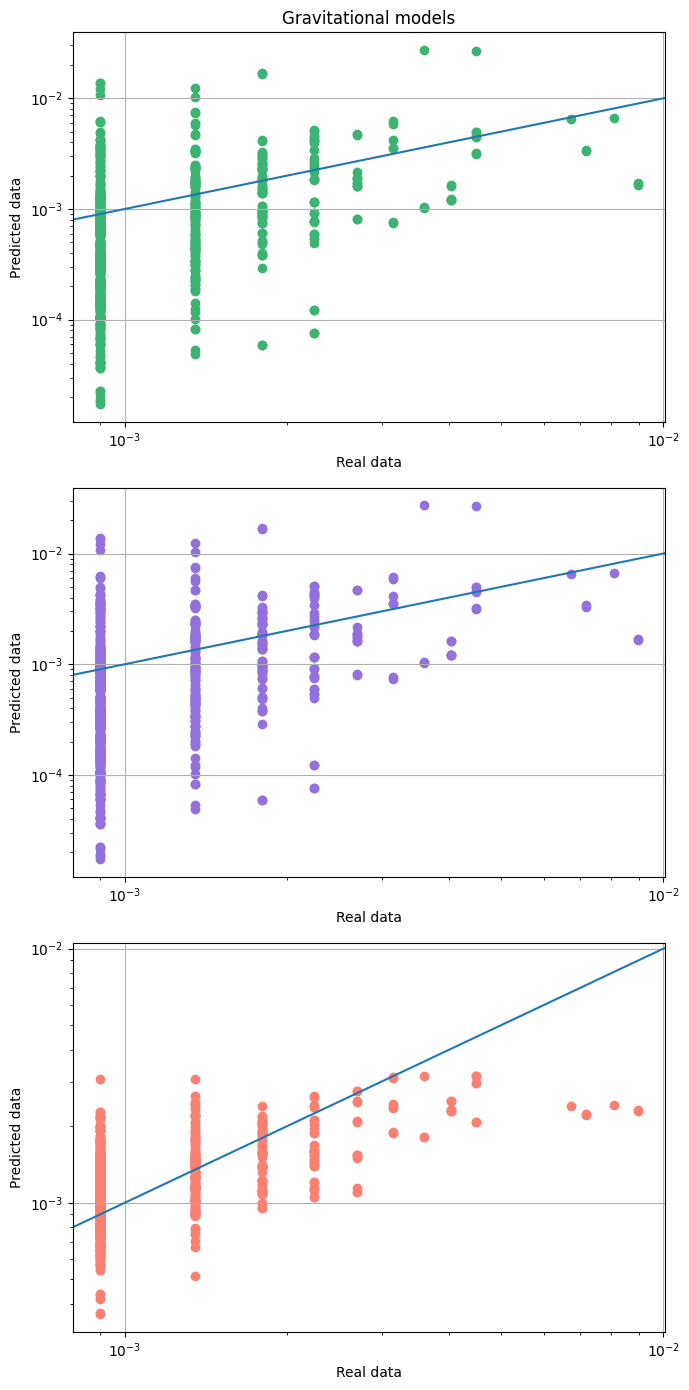

In [ ]:
# Gravitational model for level 5
plot_real_theo_grav(trips_5, theo_trips_1_5, theo_trips_2_5, theo_trips_3_5)

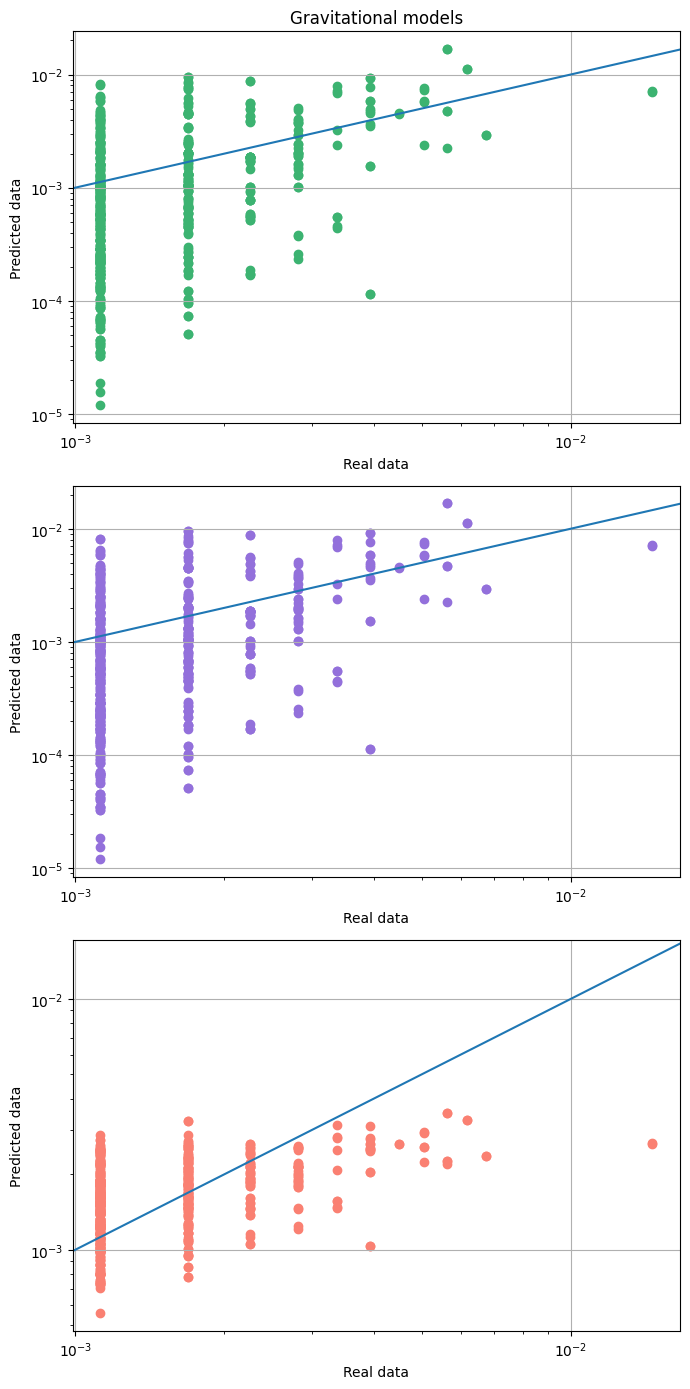

In [ ]:
# Gravitational model for level 6
plot_real_theo_grav(trips_6, theo_trips_1_6, theo_trips_2_6, theo_trips_3_6)

### Radiation Model

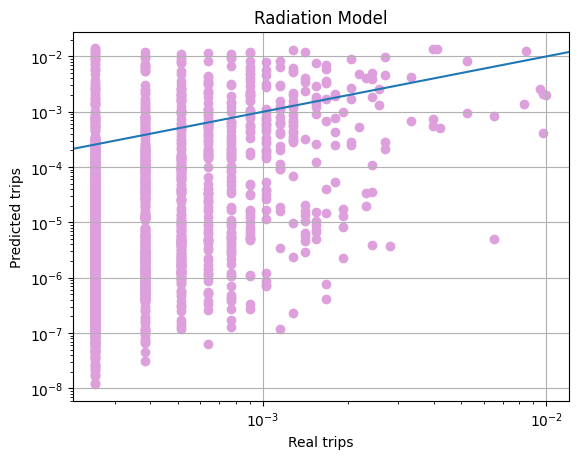

In [ ]:
# Computing the predicted values given by the radiation model for each socio economic level
T_ij_1 = radiation_model(level_1_df)
T_ij_2 = radiation_model(level_2_df)
T_ij_3 = radiation_model(level_3_df)
T_ij_4 = radiation_model(level_4_df)
T_ij_5 = radiation_model(level_5_df)
T_ij_6 = radiation_model(level_6_df)

# Ploting the radiation model for the level 
plot_radiation(level_1_df, T_ij_1)

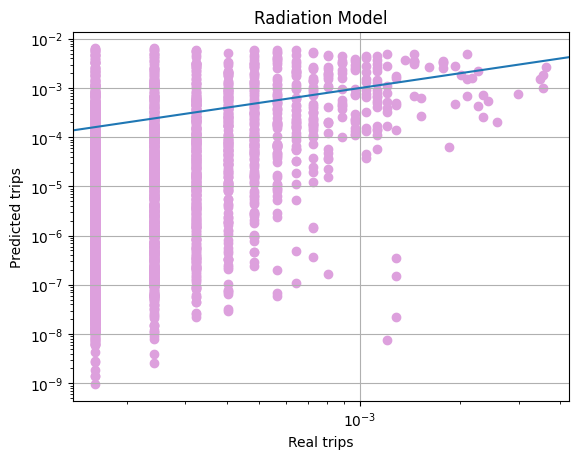

In [ ]:
# Ploting the radiation model for the level 
plot_radiation(level_2_df, T_ij_2)

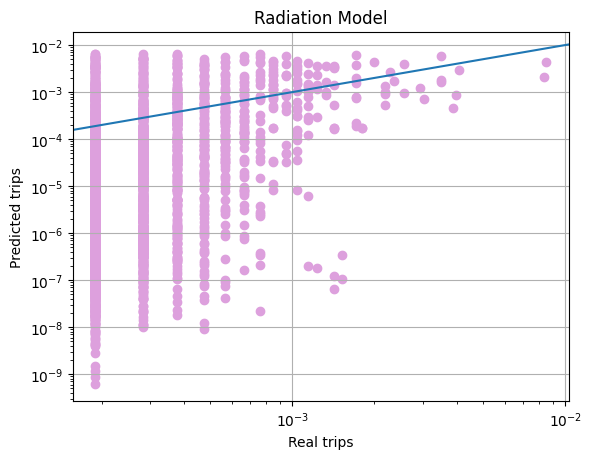

In [ ]:
# Ploting the radiation model for the level 
plot_radiation(level_3_df, T_ij_3)

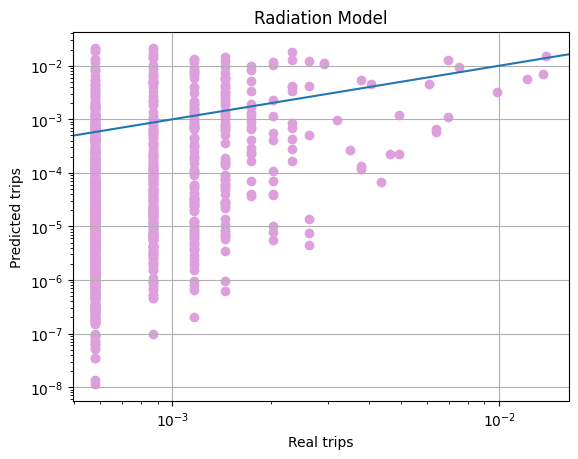

In [ ]:
# Ploting the radiation model for the level 
plot_radiation(level_4_df, T_ij_4)

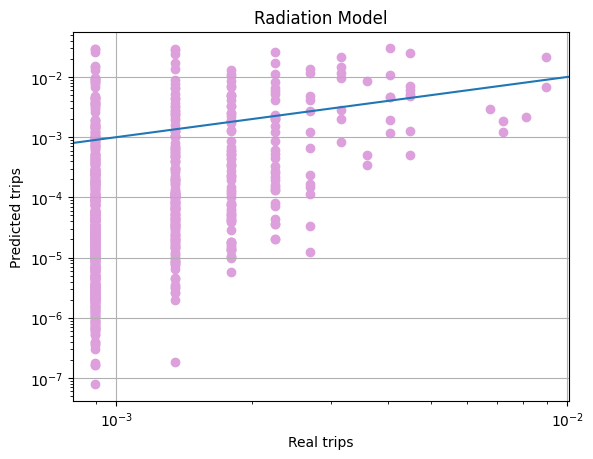

In [ ]:
# Ploting the radiation model for the level 
plot_radiation(level_5_df, T_ij_5)

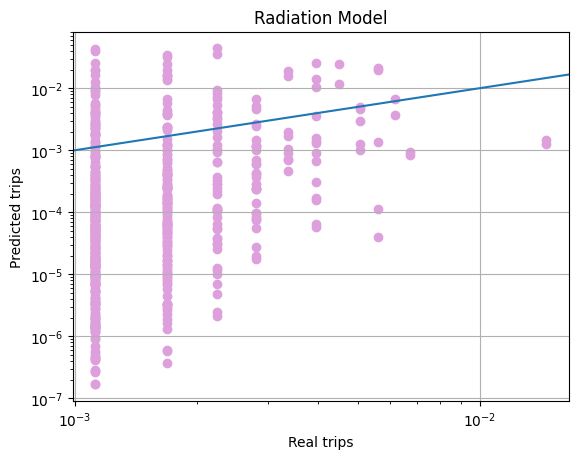

In [ ]:
# Ploting the radiation model for the level 
plot_radiation(level_6_df, T_ij_6)

# Comentarios generales

Habiendo hecho una revisión rapida de la literatura en donde se compara el modelo gravitacional con datos reales, se nota que los resultadoos que yo he obtenido son coerentes y siguen el comportamiento de lo que ya se ha publicado, lo cual me quita un peso gigante de encima.

Otra cosa importante es que se eliminaron los links con solo un viajero registrado y los cambios no fueron tan significativos como yo lo espereaba, es mas, casi que no cambiaron, por lo cual parece no ser necesario hacer este tipo de filtrado ya que los datos aun son coherentes con lo que uno se llega a encontrar en la literatura.

Algo importante a remarcar es que los dos primeros modelos gravitacionales son practiacmente lo mismo y no presentan una diferncia relevante en su comportamiento, por lo cual se puede pasar de el

# Proximas tareas

1. Puede que ambas redes no sean tan comparables, pero en la estadistica si deben poderse hacer comparaciones interesantes, pero sería limitarse a decir hipotesis de porque la red cambio tanto, sin llegar a probar, simplemente decir, paso esto y en futuros trabajos se podria probar la veracidad de dicha hipotesis.
2. Revisando bibliografia, existe una manera formal de calcular el modelo de radiaciones en terminos de cantidades de redes complejas, la cual está en [Masucci, A. P., Serras, J., Johansson, A., & Batty, M. (2013). Gravity versus radiation models: On the importance of scale and heterogeneity in commuting flows. Physical Review E—Statistical, Nonlinear, and Soft Matter Physics, 88(2), 022812.], lo ideal sería aplicar este modelo a nuestro caso, y la versión exponencial del modelo gravitacional.